<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/JB_Introduction_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# evaluate a persistence model
import pandas as pd
import numpy as np
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import Grouper
from pandas import Series
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
#from math import sqrt
from numpy import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# II- Data Preparation

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
print(type(series))
print(series.head())
print(series.size)

<class 'pandas.core.series.Series'>
Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64
365


A time series dataset depicting the total number of female births recording in California, USA during the year of 1959.

 header=0: We must specify the header information at row 0.

 parse dates=True: We give the function a hint that data in the first column contains
dates that need to be parsed.

 index col=0: We hint that the first column contains the index information for the time
series.

 squeeze=True: We hint that we only have one data column and that we are interested in
a Series and not a DataFrame

In [ ]:
print(series['1959-01'])

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
1959-01-06    29
1959-01-07    45
1959-01-08    43
1959-01-09    38
1959-01-10    27
1959-01-11    38
1959-01-12    33
1959-01-13    55
1959-01-14    47
1959-01-15    45
1959-01-16    37
1959-01-17    50
1959-01-18    43
1959-01-19    41
1959-01-20    52
1959-01-21    34
1959-01-22    53
1959-01-23    39
1959-01-24    32
1959-01-25    37
1959-01-26    43
1959-01-27    39
1959-01-28    35
1959-01-29    44
1959-01-30    38
1959-01-31    24
Name: Births, dtype: int64


In [ ]:
print(series.describe())

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: Births, dtype: float64


# Chap 5 Basic Feature Engineering

Time Series data must be re-framed as a supervised learning dataset before we can start using
machine learning algorithms. There is no concept of input and output features in time series.
Instead, we must choose the variable to be predicted and use feature engineering to construct
all of the inputs that will be used to make predictions for future time steps. In this tutorial,
you will discover how to perform feature engineering on time series data with Python to model
your time series problem with machine learning algorithms.

 Date Time Features: these are components of the time step itself for each observation.

 Lag Features: these are values at prior time steps.

 Window Features: these are a summary of values over a fixed window of prior time
steps

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                  header=0, index_col=0,parse_dates=True, squeeze=True)
print(series)
dataframe = DataFrame()
dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['temperature'] = [series[i] for i in range(len(series))]
print(dataframe.head(5))

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 3650, dtype: float64
   month  day  temperature
0      1    1         20.7
1      1    2         17.9
2      1    3         18.8
3      1    4         14.6
4      1    5         15.8


Using just the month and day information alone to predict temperature is not sophisticated
and will likely result in a poor model. Nevertheless, this information coupled with additional
engineered features may ultimately result in a better model. You may enumerate all the
properties of a time-stamp and consider what might be useful for your problem, such as:

 Minutes elapsed for the day.

 Hour of day.

 Business hours or not.

 Weekend or not.

 Season of the year.

 Business quarter of the year.

 Daylight savings or not.

 Public holiday or not.

 Leap year or not.

5.5 Lag Features

Lag features are the classical way that time series forecasting problems are transformed into
supervised learning problems. The simplest approach is to predict the value at the next time
(t+1) given the value at the current time (t). The supervised learning problem with shifted
values looks as follows:

In [ ]:
temps = DataFrame(series.values)
dataframe = concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

      t   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8


In [ ]:
temps = DataFrame(series.values)
dataframe = concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-2', 't-1', 't', 't+1']
print(dataframe.head(7))

    t-2   t-1     t   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8
5  18.8  14.6  15.8  15.8
6  14.6  15.8  15.8  15.8


Again, you can see that we must discard the first few rows that do not have enough data to
train a supervised model. A difficulty with the sliding window approach is how large to make
the window for your problem. Perhaps a good starting point is to perform a sensitivity analysis
and try a suite of different window widths to in turn create a suite of different views of your
dataset and see which results in better performing models. There will be a point of diminishing
returns.

Additionally, why stop with a linear window? Perhaps you need a lag value from last week,
last month, and last year. Again, this comes down to the specific domain. In the case of the
temperature dataset, a lag value from the same day in the previous year or previous few years
may be useful. We can do more with a window than include the raw values. In the next section,
we’ll look at including features that summarize statistics across the window.

5.6 Rolling Window Statistics

In [ ]:
temps = DataFrame(series.values)
print('temps',temps)
shifted = temps.shift(1)
print('shifted',shifted)
window = shifted.rolling(window=2)
print('window',window)
means = window.mean()
print('window.mean()',means)
dataframe = concat([means, temps], axis=1)
dataframe.columns = ['mean(t-1,t)', 't+1']
print('dataframe',dataframe.head(5))

temps          0
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
3645  14.0
3646  13.6
3647  13.5
3648  15.7
3649  13.0

[3650 rows x 1 columns]
shifted          0
0      NaN
1     20.7
2     17.9
3     18.8
4     14.6
...    ...
3645  14.6
3646  14.0
3647  13.6
3648  13.5
3649  15.7

[3650 rows x 1 columns]
window Rolling [window=2,center=False,axis=0]
window.mean()           0
0       NaN
1       NaN
2     19.30
3     18.35
4     16.70
...     ...
3645  13.75
3646  14.30
3647  13.80
3648  13.55
3649  14.60

[3650 rows x 1 columns]
dataframe    mean(t-1,t)   t+1
0          NaN  20.7
1          NaN  17.9
2        19.30  18.8
3        18.35  14.6
4        16.70  15.8


In [ ]:
temps = DataFrame(series.values)
print('temps',temps)
width = 3
shifted = temps.shift(width - 1)
print('shifted',shifted)
window = shifted.rolling(window=width)
print('window',window)
dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print('dataframe \n',dataframe.head(10))

temps          0
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
3645  14.0
3646  13.6
3647  13.5
3648  15.7
3649  13.0

[3650 rows x 1 columns]
shifted          0
0      NaN
1      NaN
2     20.7
3     17.9
4     18.8
...    ...
3645  12.9
3646  14.6
3647  14.0
3648  13.6
3649  13.5

[3650 rows x 1 columns]
window Rolling [window=3,center=False,axis=0]
dataframe 
     min       mean   max   t+1
0   NaN        NaN   NaN  20.7
1   NaN        NaN   NaN  17.9
2   NaN        NaN   NaN  18.8
3   NaN        NaN   NaN  14.6
4  17.9  19.133333  20.7  15.8
5  14.6  17.100000  18.8  15.8
6  14.6  16.400000  18.8  15.8
7  14.6  15.400000  15.8  17.4
8  15.8  15.800000  15.8  21.8
9  15.8  16.333333  17.4  20.0


5.7 Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is
called an expanding window and can help with keeping track of the bounds of observable data.
Like the rolling() function on DataFrame, Pandas provides an expanding() function4 that
collects sets of all prior values for each time step.

These lists of prior numbers can be summarized and included as new features. For example,
below are the lists of numbers in the expanding window for the first 5 time steps of the series:

Window Values

1, NaN

2, NaN, 20.7

3, NaN, 20.7, 17.9,

4, NaN, 20.7, 17.9, 18.8

5, NaN, 20.7, 17.9, 18.8, 14.6


In [ ]:
temps = DataFrame(series.values)
print(temps)
window = temps.expanding()
dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(5))

         0
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
3645  14.0
3646  13.6
3647  13.5
3648  15.7
3649  13.0

[3650 rows x 1 columns]
    min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8


# Chap 6 Data Visualization

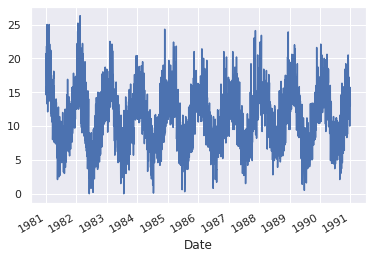

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                  header=0, index_col=0,parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

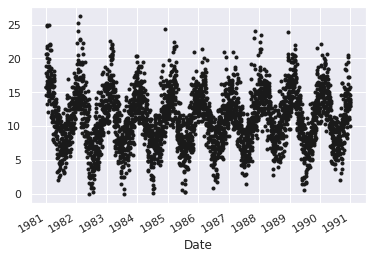

In [ ]:
series.plot(style='k.')
pyplot.show()

In [ ]:
groups = series.groupby(Grouper(freq='A'))
for name, group in groups:
  print(name)
  print(group)

1981-12-31 00:00:00
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1981-12-27    15.5
1981-12-28    13.3
1981-12-29    15.6
1981-12-30    15.2
1981-12-31    17.4
Name: Temp, Length: 365, dtype: float64
1982-12-31 00:00:00
Date
1982-01-01    17.0
1982-01-02    15.0
1982-01-03    13.5
1982-01-04    15.2
1982-01-05    13.0
              ... 
1982-12-27    15.3
1982-12-28    16.3
1982-12-29    15.8
1982-12-30    17.7
1982-12-31    16.3
Name: Temp, Length: 365, dtype: float64
1983-12-31 00:00:00
Date
1983-01-01    18.4
1983-01-02    15.0
1983-01-03    10.9
1983-01-04    11.4
1983-01-05    14.8
              ... 
1983-12-27    13.9
1983-12-28    11.1
1983-12-29    16.1
1983-12-30    20.4
1983-12-31    18.0
Name: Temp, Length: 365, dtype: float64
1984-12-31 00:00:00
Date
1984-01-01    19.5
1984-01-02    17.1
1984-01-03    17.1
1984-01-04    12.0
1984-01-05    11.0
              ... 
1984-12-26    12.2
1984-12-27    12.0
1

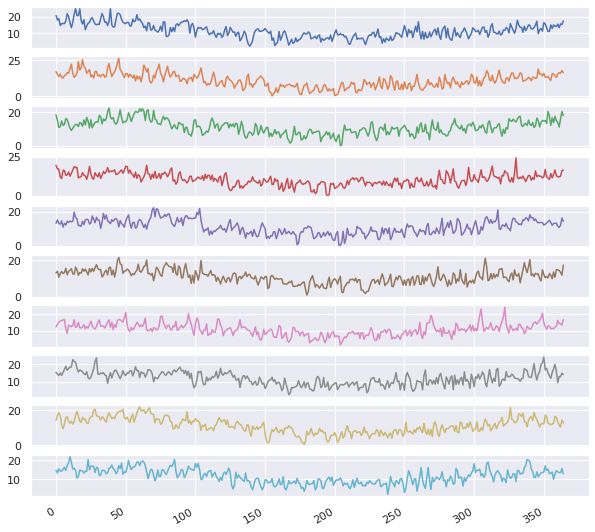

In [ ]:
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.plot(subplots=True, legend=False,figsize=(10,10))
pyplot.show()

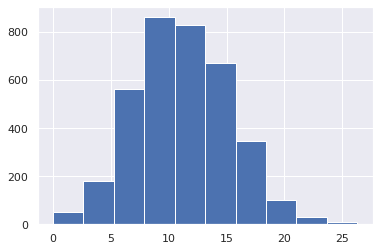

In [ ]:
series.hist()
pyplot.show()

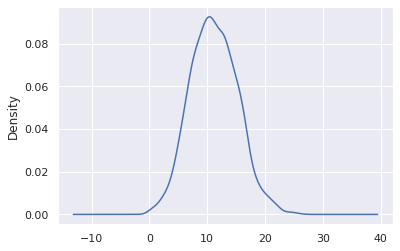

In [ ]:
series.plot(kind='kde')
pyplot.show()

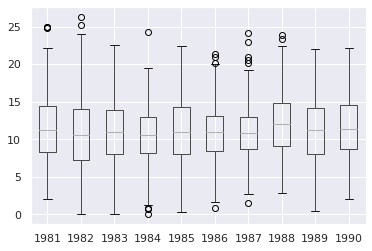

In [ ]:
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

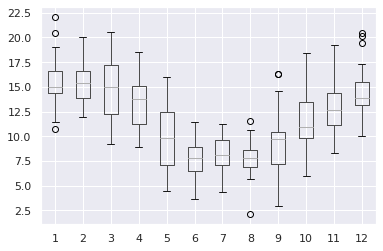

In [ ]:
one_year = series['1990']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
months.boxplot()
pyplot.show()

In [ ]:
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years = years.T
years

0     1     2     3     4     5    ...   359   360   361   362   363   364
1981  20.7  17.9  18.8  14.6  15.8  15.8  ...  14.0  15.5  13.3  15.6  15.2  17.4
1982  17.0  15.0  13.5  15.2  13.0  12.5  ...  13.0  15.3  16.3  15.8  17.7  16.3
1983  18.4  15.0  10.9  11.4  14.8  12.1  ...  15.0  13.9  11.1  16.1  20.4  18.0
1984  19.5  17.1  17.1  12.0  11.0  16.3  ...  12.8  12.2  12.0  12.6  16.0  16.4
1985  13.3  15.2  13.1  12.7  14.6  11.0  ...  13.3  11.5  10.8  12.0  16.3  14.4
1986  12.9  13.8  10.6  12.6  13.7  12.6  ...  14.7  14.6  14.2  13.2  11.7  17.2
1987  12.3  13.8  15.3  15.6  16.2  16.3  ...  12.7  16.2  14.2  14.3  13.3  16.7
1988  15.3  14.3  13.5  15.0  13.6  15.2  ...  15.8   9.5  12.9  12.9  14.8  14.1
1989  14.3  17.4  18.5  16.8  11.5   9.5  ...  16.0  13.3  11.7  10.4  14.4  12.7
1990  14.8  13.3  15.6  14.5  14.3  15.3  ...  14.6  14.0  13.6  13.5  15.7  13.0

[10 rows x 365 columns]

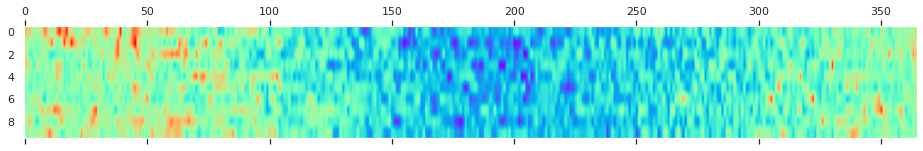

In [ ]:
pyplot.matshow(years, interpolation=None, aspect='auto',cmap='rainbow')
pyplot.grid(b=None)
pyplot.show()

The plot shows the cooler minimum temperatures in the middle days of the years and
the warmer minimum temperatures in the start and ends of the years, and all the fading and
complexity in between.

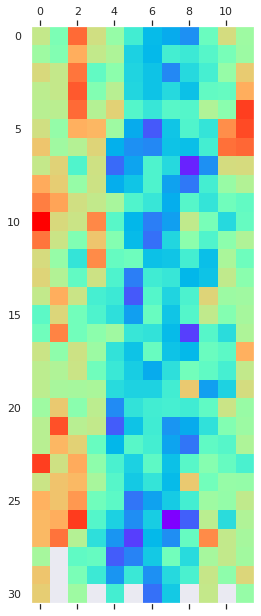

In [ ]:
one_year = series['1990']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
pyplot.matshow(months, interpolation=None, aspect='auto',cmap='rainbow')
pyplot.grid(b=None)
pyplot.show()

6.7 Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation.
Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag=2, and so on. A useful type of plot
to explore the relationship between each observation and a lag of that observation is called the
scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the
observation at time t on the x-axis and the observation at the next time step (t+1) on the
y-axis.

 If the points cluster along a diagonal line from the bottom-left to the top-right of the plot,
it suggests a positive correlation relationship.

 If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests
a negative correlation relationship.

 Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread
from the line suggests a weaker relationship. A ball in the middle or a spread across the plot
suggests a weak or no relationship. Below is an example of a lag plot for the Minimum Daily
Temperatures dataset.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


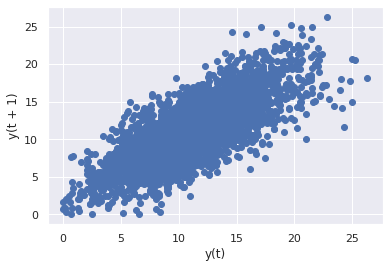

In [ ]:
lag_plot(series)
pyplot.show()

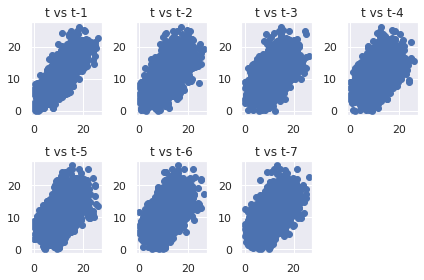

In [ ]:
values = DataFrame(series.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
  columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
  columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
  ax = pyplot.subplot(240 + i)
  ax.set_title('t vs t-' + str(i))
  pyplot.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
pyplot.tight_layout()
pyplot.show()

Running the example suggests the strongest relationship between an observation with its
lag=1 value, but generally a good positive correlation with each value in the last week.

6.8 Autocorrelation Plots

We can quantify the strength and type of relationship between observations and their lags. In
statistics, this is called correlation, and when calculated against lag values in time series, it is
called autocorrelation (self-correlation). A correlation value calculated between two groups of
numbers, such as observations and their lag=1 values, results in a number between -1 and 1.
The sign of this number indicates a negative or positive correlation respectively. A value close to
zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.

Correlation values, called correlation coefficients, can be calculated for each observation and
different lag values. Once calculated, a plot can be created to help better understand how this
relationship changes over the lag. This type of plot is called an autocorrelation plot and Pandas provides this capability built in, called the autocorrelation plot() function. The example
below creates an autocorrelation plot for the Minimum Daily Temperatures dataset:

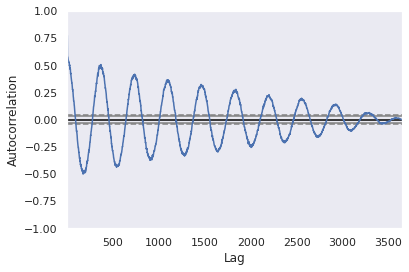

In [ ]:
autocorrelation_plot(series)
pyplot.show()

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines
are provided that indicate any correlation values above those lines are statistically significant
(meaningful). We can see that for the Minimum Daily Temperatures dataset we see cycles of
strong negative and positive correlation. This captures the relationship of an observation with
past observations in the same and opposite seasons or times of year. Sine waves like those seen
in this example are a strong sign of seasonality in the dataset.

In [ ]:
lag=3
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
print(dataframe[:200])
dataframe.corr()

        t   t+3
0     NaN  20.7
1     NaN  17.9
2     NaN  18.8
3    20.7  14.6
4    17.9  15.8
..    ...   ...
195   5.7   7.2
196   6.1   6.3
197   7.0   8.8
198   7.2   5.0
199   6.3   7.4

[200 rows x 2 columns]


t       t+3
t    1.000000  0.586375
t+3  0.586375  1.000000

In [ ]:
lag=100
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
print(dataframe[:200])
dataframe.corr()

        t  t+100
0     NaN   20.7
1     NaN   17.9
2     NaN   18.8
3     NaN   14.6
4     NaN   15.8
..    ...    ...
195  16.6    7.2
196  10.0    6.3
197  14.9    8.8
198  15.9    5.0
199  13.0    7.4

[200 rows x 2 columns]


t     t+100
t      1.000000 -0.104352
t+100 -0.104352  1.000000

In [ ]:
lag=200
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
print(dataframe)
dataframe.corr()

         t  t+200
0      NaN   20.7
1      NaN   17.9
2      NaN   18.8
3      NaN   14.6
4      NaN   15.8
...    ...    ...
3645  10.3   14.0
3646   7.2   13.6
3647   7.4   13.5
3648  11.4   15.7
3649   5.4   13.0

[3650 rows x 2 columns]


t     t+200
t      1.000000 -0.502494
t+200 -0.502494  1.000000

# Chapter 7 Resampling and Interpolation

7.1 Resampling

Resampling involves changing the frequency of your time series observations. Two types of
resampling are:

 Upsampling: Where you increase the frequency of the samples, such as from minutes to
seconds.

 Downsampling: Where you decrease the frequency of the samples, such as from days to
months.

7.3 Upsampling Data

This dataset describes the monthly number of sales of shampoo over a 3 year period. The units
are a sales count and there are 36 observations. The original dataset is credited to Makridakis,
Wheelwright and Hyndman (1998). The code below loads the Shampoo Sales dataset, prints
the first 5 rows of data and graphs the data as a line plot

In [ ]:
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
print(series)
upsampled = series.resample('D').mean()
print(upsampled.head(32))

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64
Month
1901-01-01    266.0
1901-01-02      NaN
1901-01-03      NaN
1901-01-04      NaN
1901-01-05      NaN
1901-01-06      NaN
1901-01-07      NaN
1901-01-08      NaN
1901-01-09      NaN
1901-01-10      NaN
1901-01-11      NaN
1901-01-12      NaN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


We can see that the resample() function has created the rows by putting NaN values in the
new values. We can see we still have the sales volume on the first of January and February from
the original data. Next, we can interpolate the missing values at this new frequency. The Series
Pandas object provides an interpolate() function to interpolate missing values, and there is
a nice selection of simple and more complex interpolation functions. You may have domain
knowledge to help choose how values are to be interpolated. A good starting point is to use a
linear interpolation. This draws a straight line between available data, in this case on the first
of the month, and fills in values at the chosen frequency from this line.

Month
1901-01-01    266.000000
1901-01-02    262.125806
1901-01-03    258.251613
1901-01-04    254.377419
1901-01-05    250.503226
1901-01-06    246.629032
1901-01-07    242.754839
1901-01-08    238.880645
1901-01-09    235.006452
1901-01-10    231.132258
1901-01-11    227.258065
1901-01-12    223.383871
1901-01-13    219.509677
1901-01-14    215.635484
1901-01-15    211.761290
1901-01-16    207.887097
1901-01-17    204.012903
1901-01-18    200.138710
1901-01-19    196.264516
1901-01-20    192.390323
1901-01-21    188.516129
1901-01-22    184.641935
1901-01-23    180.767742
1901-01-24    176.893548
1901-01-25    173.019355
1901-01-26    169.145161
1901-01-27    165.270968
1901-01-28    161.396774
1901-01-29    157.522581
1901-01-30    153.648387
1901-01-31    149.774194
1901-02-01    145.900000
1901-02-02    147.228571
1901-02-03    148.557143
1901-02-04    149.885714
1901-02-05    151.214286
1901-02-06    152.542857
1901-02-07    153.871429
1901-02-08    155.200000
1901-02-09    156.5

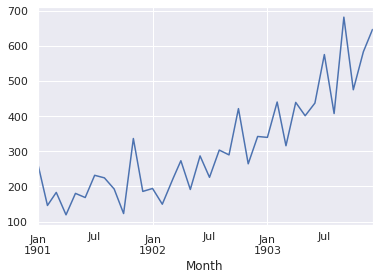

In [ ]:
upsampled = series.resample('D').mean()
interpolated = upsampled.interpolate(method='linear')
print(interpolated.head(40))
interpolated.plot()
pyplot.show()

Another common interpolation method is to use a polynomial or a spline to connect the
values. This creates more curves and can look more natural on many datasets. Using a spline
interpolation requires you specify the order (number of terms in the polynomial); in this case,
an order of 2 is just fine.

Month
1901-01-01    266.000000
1901-01-02    258.630160
1901-01-03    251.560886
1901-01-04    244.720748
1901-01-05    238.109746
1901-01-06    231.727880
1901-01-07    225.575149
1901-01-08    219.651553
1901-01-09    213.957094
1901-01-10    208.491770
1901-01-11    203.255582
1901-01-12    198.248529
1901-01-13    193.470612
1901-01-14    188.921831
1901-01-15    184.602185
1901-01-16    180.511676
1901-01-17    176.650301
1901-01-18    173.018063
1901-01-19    169.614960
1901-01-20    166.440993
1901-01-21    163.496161
1901-01-22    160.780465
1901-01-23    158.293905
1901-01-24    156.036481
1901-01-25    154.008192
1901-01-26    152.209039
1901-01-27    150.639021
1901-01-28    149.298139
1901-01-29    148.186393
1901-01-30    147.303783
1901-01-31    146.650308
1901-02-01    145.900000
Freq: D, Name: Sales, dtype: float64


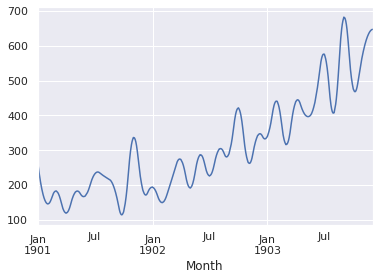

In [ ]:
upsampled = series.resample('D').mean()
interpolated = upsampled.interpolate(method='spline', order=2)
print(interpolated.head(32))
interpolated.plot()
pyplot.show()

7.4 Downsampling Data

The sales data is monthly, but perhaps we would prefer the data to be quarterly. The year can
be divided into 4 business quarters, 3 months a piece. Instead of creating new rows between
existing observations, the resample() function in Pandas will group all observations by the
new frequency.

We could use an alias like 3M to create groups of 3 months, but this might have trouble if our
observations did not start in January, April, July, or October. Pandas does have a quarter-aware
alias of Q that we can use for this purpose. We must now decide how to create a new quarterly
value from each group of 3 records. A good starting point is to calculate the average monthly
sales numbers for the quarter. For this, we can use the mean() function. Putting this all
together, we get the following code example

Month
1901-03-31    198.333333
1901-06-30    156.033333
1901-09-30    216.366667
1901-12-31    215.100000
1902-03-31    184.633333
Freq: Q-DEC, Name: Sales, dtype: float64


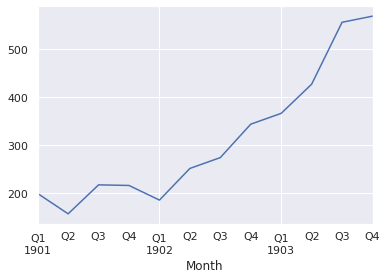

In [ ]:
resample = series.resample('Q')
quarterly_mean_sales = resample.mean()
print(quarterly_mean_sales.head())
quarterly_mean_sales.plot()
pyplot.show()

Month
1901-12-31    2357.5
1902-12-31    3153.5
1903-12-31    5742.6
Freq: A-DEC, Name: Sales, dtype: float64


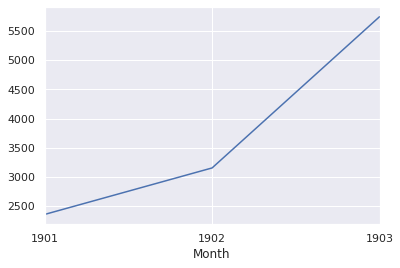

In [ ]:
resample = series.resample('A')
yearly_mean_sales = resample.sum()
print(yearly_mean_sales.head())
yearly_mean_sales.plot()
pyplot.show()

# Chapter 8 Power Transforms

This dataset describes the total number of airline passengers over time. The units are a count of
the number of airline passengers in thousands. There are 144 monthly observations from 1949
to 1960. The code below loads the Airline Passengers dataset, prints the first 5 rows of data
and graphs the data as a line plot.

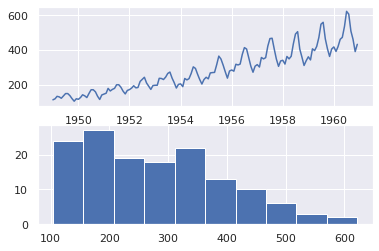

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(series)
# histogram
pyplot.subplot(212)
pyplot.hist(series)
pyplot.show()

The dataset is non-stationary, meaning that the mean and the variance of the observations
change over time. This makes it difficult to model by both classical statistical methods, like
ARIMA, and more sophisticated machine learning methods, like neural networks. This is caused
by what appears to be both an increasing trend and a seasonality component.

In addition, the amount of change, or the variance, is increasing with time. This is clear
when you look at the size of the seasonal component and notice that from one cycle to the
next, the amplitude (from bottom to top of the cycle) is increasing. In this tutorial, we will
investigate transforms that we can use on time series datasets that exhibit this property.

8.2 Square Root Transform

A time series that has a quadratic growth trend can be made linear by taking the square root.
Let’s demonstrate this with a quick contrived example. Consider a series of the numbers 1 to 99
squared. The line plot of this series will show a quadratic growth trend and a histogram of the
values will show an exponential distribution with a long tail. The snippet of code below creates
and graphs this series.

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


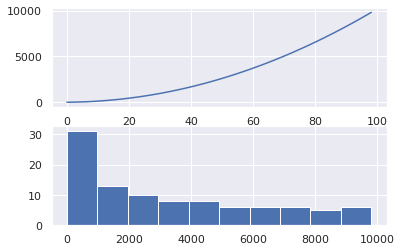

In [ ]:
# contrive a quadratic time series
series = [i**2 for i in range(1,100)]
print(series)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(series)
# histogram
pyplot.subplot(212)
pyplot.hist(series)
pyplot.show()

If you see a structure like this in your own time series, you may have a quadratic growth
trend. This can be removed or made linear by taking the inverse operation of the squaring
procedure, which is the square root. Because the example is perfectly quadratic, we would
expect the line plot of the transformed data to show a straight line. 

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97. 98. 99.]


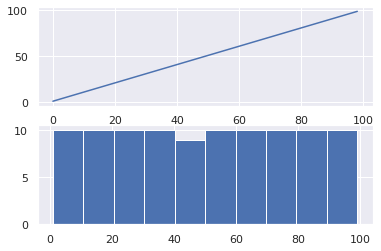

In [ ]:
series = [i**2 for i in range(1,100)]
print(series)
# sqrt transform
transform =sqrt(series)
print(transform)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(transform)
# histogram
pyplot.subplot(212)
pyplot.hist(transform)
pyplot.show()

     passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         606
140         508
141         461
142         390
143         432

[144 rows x 1 columns]


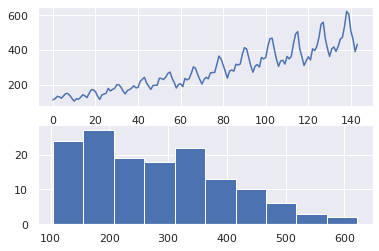

     passengers
0     10.583005
1     10.862780
2     11.489125
3     11.357817
4     11.000000
..          ...
139   24.617067
140   22.538855
141   21.470911
142   19.748418
143   20.784610

[144 rows x 1 columns]


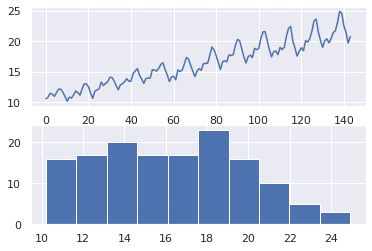

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
dataframe = DataFrame(series.values)
dataframe.columns = ['passengers']
print(dataframe)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()

dataframe['passengers'] = sqrt(dataframe['passengers'])
print(dataframe)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()

8.3 Log Transform

[2.718281828459045, 7.38905609893065, 20.085536923187668, 54.598150033144236, 148.4131591025766, 403.4287934927351, 1096.6331584284585, 2980.9579870417283, 8103.083927575384, 22026.465794806718, 59874.14171519782, 162754.79141900392, 442413.3920089205, 1202604.2841647768, 3269017.3724721107, 8886110.520507872, 24154952.7535753, 65659969.13733051, 178482300.96318725, 485165195.4097903, 1318815734.4832146, 3584912846.131592, 9744803446.248903, 26489122129.84347, 72004899337.38588, 195729609428.83878, 532048240601.79865, 1446257064291.475, 3931334297144.042, 10686474581524.463, 29048849665247.426, 78962960182680.69, 214643579785916.06, 583461742527454.9, 1586013452313430.8, 4311231547115195.0, 1.1719142372802612e+16, 3.1855931757113756e+16, 8.659340042399374e+16, 2.3538526683702e+17, 6.398434935300549e+17, 1.739274941520501e+18, 4.727839468229346e+18, 1.2851600114359308e+19, 3.4934271057485095e+19, 9.496119420602448e+19, 2.5813128861900675e+20, 7.016735912097631e+20, 1.9073465724950998e+2

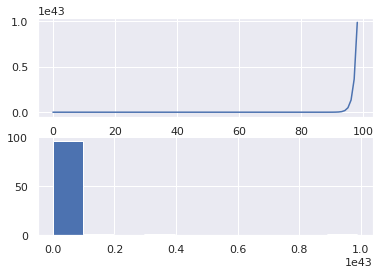

In [ ]:
from math import exp
series = [exp(i) for i in range(1,100)]
print(series)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(series)
# histogram
pyplot.subplot(212)
pyplot.hist(series)
pyplot.show()

Again, we can transform this series back to linear by taking the natural logarithm of the
values. This would make the series linear and the distribution uniform. The example below
demonstrates this for completeness.

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97. 98. 99.]


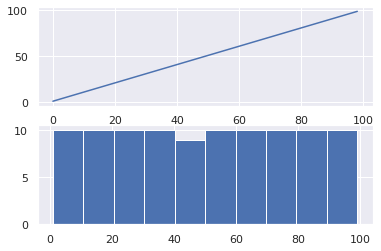

In [ ]:
from math import exp
from numpy import log
series = [exp(i) for i in range(1,100)]
transform = log(series)
print(transform)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(transform)
# histogram
pyplot.subplot(212)
pyplot.hist(transform)
pyplot.show()

Our Airline Passengers dataset has a distribution of this form, but perhaps not this extreme.
The example below demonstrates a log transform of the Airline Passengers dataset.

     passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         606
140         508
141         461
142         390
143         432

[144 rows x 1 columns]


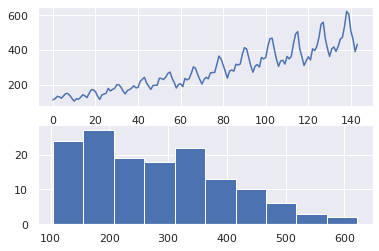

     passengers
0      4.718499
1      4.770685
2      4.882802
3      4.859812
4      4.795791
..          ...
139    6.406880
140    6.230481
141    6.133398
142    5.966147
143    6.068426

[144 rows x 1 columns]


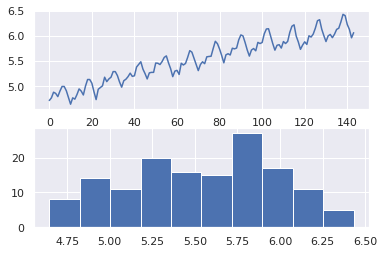

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
dataframe = DataFrame(series.values)
dataframe.columns = ['passengers']
print(dataframe)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()
dataframe['passengers'] = log(dataframe['passengers'])
print(dataframe)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()

8.4 Box-Cox Transform

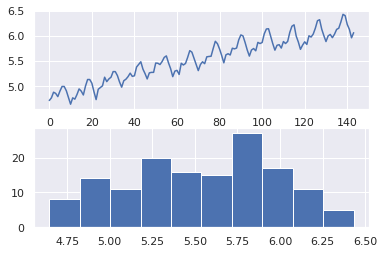

In [ ]:
from scipy.stats import boxcox
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
dataframe = DataFrame(series.values)
dataframe.columns = ['passengers']
dataframe['passengers'] = boxcox(dataframe['passengers'], lmbda=0.0)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()


Lambda: 0.148023


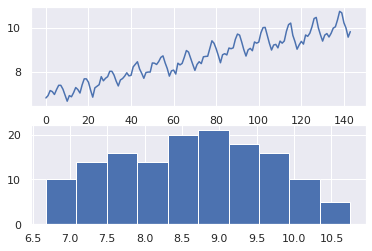

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
dataframe = DataFrame(series.values)
dataframe.columns = ['passengers']
dataframe['passengers'], lam = boxcox(dataframe['passengers'])
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['passengers'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['passengers'])
pyplot.show()

The line and histogram plots are also very similar to those from the log transform.

# Chapter 9 Moving Average Smoothing

Smoothing is a technique applied to time series to remove the fine-grained variation between
time steps. The hope of smoothing is to remove noise and better expose the signal of the
underlying causal processes. Moving averages are a simple and common type of smoothing
used in time series analysis and time series forecasting. Calculating a moving average involves
creating a new series where the values are comprised of the average of raw observations in the
original time series.

A moving average requires that you specify a window size called the window width. This
defines the number of raw observations used to calculate the moving average value. The moving
part in the moving average refers to the fact that the window defined by the window width is
slid along the time series to calculate the average values in the new series. There are two main
types of moving average that are used: Centered and Trailing Moving Average.

series 
 Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Births, Length: 365, dtype: int64
rolling 
 Rolling [window=3,center=False,axis=0]
rolling_mean 
 Date
1959-01-01          NaN
1959-01-02          NaN
1959-01-03    32.333333
1959-01-04    31.000000
1959-01-05    35.000000
1959-01-06    34.666667
1959-01-07    39.333333
1959-01-08    39.000000
1959-01-09    42.000000
1959-01-10    36.000000
Name: Births, dtype: float64


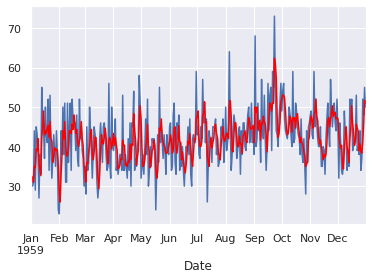

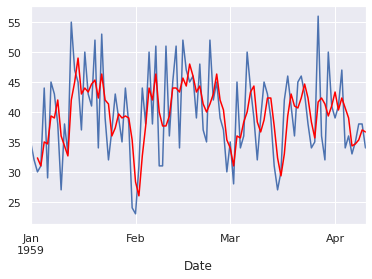

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)
# tail-rolling average transform
print('series \n',series)
rolling = series.rolling(window=3)
print('rolling \n',rolling)
rolling_mean = rolling.mean()
print('rolling_mean \n',rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()
# zoomed plot original and transformed dataset
series[:100].plot()
rolling_mean[:100].plot(color='red')
pyplot.show()

9.5 Moving Average as Feature Engineering

The moving average can be used as a source of new information when modeling a time series
forecast as a supervised learning problem. In this case, the moving average is calculated and
added as a new input feature used to predict the next time step. First, a copy of the series must
be shifted forward by one time step. This will represent the input to our prediction problem,
or a lag=1 version of the series. This is a standard supervised learning view of the time series
problem. For example:

X, y

NaN, obs1

obs1, obs2

obs2, obs3

Next, a second copy of the series needs to be shifted forward by one, minus the window size.
This is to ensure that the moving average summarizes the last few values and does not include
the value to be predicted in the average, which would be an invalid framing of the problem as
the input would contain knowledge of the future being predicted.

For example, with a window size of 3, we must shift the series forward by 2 time steps. This
is because we want to include the previous two observations as well as the current observation
in the moving average in order to predict the next value. We can then calculate the moving
average from this shifted series. Below is an example of how the first 5 moving average values
are calculated. Remember, the dataset is shifted forward 2 time steps and as we move along
the time series, it takes at least 3 time steps before we even have enough data to calculate a
window=3 moving average.

Observations, Mean

NaN NaN

NaN, NaN NaN

NaN, NaN, 35 NaN

NaN, 35, 32 NaN

30, 32, 35 32

 Remember, the dataset is shifted forward 2 time steps and as we move along
the time series, it takes at least 3 time steps before we even have enough data to calculate a
window=3 moving average.

In [ ]:
df = DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1) # shift 2
print(lag3)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't', 't+1']
print(dataframe.head(10))

        0
0     NaN
1     NaN
2    35.0
3    32.0
4    30.0
..    ...
360  44.0
361  34.0
362  37.0
363  52.0
364  48.0

[365 rows x 1 columns]
        mean     t  t+1
0        NaN   NaN   35
1        NaN  35.0   32
2        NaN  32.0   30
3        NaN  30.0   31
4  32.333333  31.0   44
5  31.000000  44.0   29
6  35.000000  29.0   45
7  34.666667  45.0   43
8  39.333333  43.0   38
9  39.000000  38.0   27


9.6 Moving Average as Prediction

In [ ]:
from numpy import mean
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', 
                  header=0, index_col=0, parse_dates=True,squeeze=True)

# prepare situation
X = series.values
print(X)
window = 3
history = [X[i] for i in range(window)]
print('history',history)
test = [X[i] for i in range(window, len(X))]
print('test',test)
predictions = list()
# walk forward over time steps in test
for t in range(len(test)): #len(test)
  print('----',t,'---------------------------------------------')
  length = len(history)
  print('length history ',length)
  print('length-window,length ',length-window,length)
  yhat = mean([history[i] for i in range(length-window,length)])
  print('yhat-predictions from history (mean) ',yhat)
  obs = test[t]
  predictions.append(yhat)
  print('predictions list',predictions)
  history.append(obs)
  print('obs - test[t]',obs)
  print('history list',history)
  print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


[35 32 30 31 44 29 45 43 38 27 38 33 55 47 45 37 50 43 41 52 34 53 39 32
 37 43 39 35 44 38 24 23 31 44 38 50 38 51 31 31 51 36 45 51 34 52 47 45
 46 39 48 37 35 52 42 45 39 37 30 35 28 45 34 36 50 44 39 32 39 45 43 39
 31 27 30 42 46 41 36 45 46 43 38 34 35 56 36 32 50 41 39 41 47 34 36 33
 35 38 38 34 53 34 34 38 35 32 42 34 46 30 46 45 54 34 37 35 40 42 58 51
 32 35 38 33 39 47 38 52 30 34 40 35 42 41 42 38 24 34 43 36 55 41 45 41
 37 43 39 33 43 40 38 45 46 34 35 48 51 36 33 46 42 48 34 41 35 40 34 30
 36 40 39 45 38 47 33 30 42 43 41 41 59 43 45 38 37 45 42 57 46 51 41 47
 26 35 44 41 42 36 45 45 45 47 38 42 35 36 39 45 43 47 36 41 50 39 41 46
 64 45 34 38 44 48 46 44 37 39 44 45 33 44 38 46 46 40 39 44 48 50 41 42
 51 41 44 38 68 40 42 51 44 45 36 57 44 42 53 42 34 40 56 44 53 55 39 59
 55 73 55 44 43 40 47 51 56 49 54 56 47 44 43 42 45 50 48 43 40 59 41 42
 51 49 45 43 42 38 47 38 36 42 35 28 44 36 45 46 48 49 43 42 59 45 52 46
 42 40 40 45 35 35 40 39 33 42 47 51 44 40 57 49 45

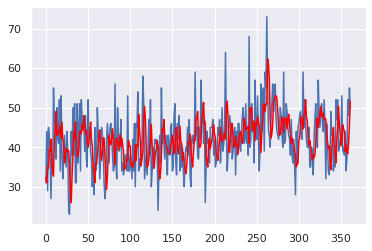

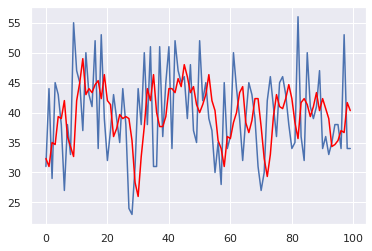

In [ ]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# zoom plot
pyplot.plot(test[:100])
pyplot.plot(predictions[:100], color='red')
pyplot.show()

# III- Temporal Structure

# Chapter 10 A Gentle Introduction to White Noise

White noise is an important concept in time series forecasting. If a time series is white noise, it
is a sequence of random numbers and cannot be predicted. If the series of forecast errors are not
white noise, it suggests improvements could be made to the predictive model. In this tutorial,
you will discover white noise time series with Python

A time series may be white noise. A time series is white noise if the variables are independent
and identically distributed with a mean of zero. This means that all variables have the same
variance (sigma2) and each value has a zero correlation with all other values in the series. If
the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian
white noise.

Some tools that you can use to check if your time series is white noise are:

 Create a line plot. Check for gross features like a changing mean, variance, or obvious
relationship between lagged variables.

 Calculate summary statistics. Check the mean and variance of the whole series against
the mean and variance of meaningful contiguous blocks of values in the series (e.g. days,
months, or years).

 Create an autocorrelation plot. Check for gross correlation between lagged variables.

count    1000.000000
mean       -0.013222
std         1.003685
min        -2.961214
25%        -0.684192
50%        -0.010934
75%         0.703915
max         2.737260
dtype: float64


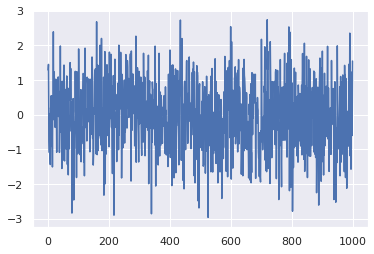

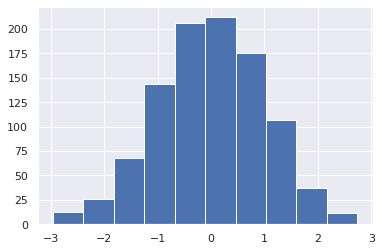

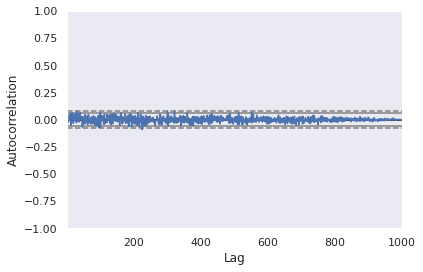

In [ ]:
# calculate and plot a white noise series
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)
# summary stats
print(series.describe())
# line plot
series.plot()
pyplot.show()
# histogram plot
series.hist()
pyplot.show()
# autocorrelation
autocorrelation_plot(series)
pyplot.show()

# Chapter 11 A Gentle Introduction to the Random Walk

How do you know your time series problem is predictable? This is a difficult question with
time series forecasting. There is a tool called a random walk that can help you understand the
predictability of your time series forecast problem. In this tutorial, you will discover the random
walk and its properties in Python. After completing this tutorial, you will know:

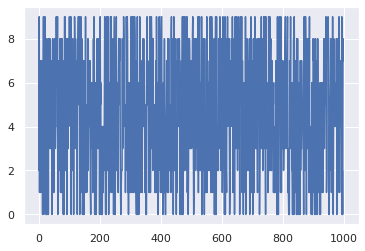

In [ ]:
from random import seed
from random import randrange
from matplotlib import pyplot
seed(1)
series = [randrange(10) for i in range(1000)]
pyplot.plot(series)
pyplot.show()

This is not a random walk. It is just a sequence of random numbers also called white noise
(see Chapter 10). A common mistake that beginners make is to think that a random walk is a
list of random numbers, and this is not the case at all.

In [ ]:
# create and plot a random walk
from random import seed
from random import random
from matplotlib import pyplot
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
print('random_walk',random_walk)
for i in range(1, 1000):
  print(i,'------------------------------')
  movement = -1 if random() < 0.5 else 1
  print('movement',movement)
  print(' random_walk[i-1]', random_walk[i-1])
  value = random_walk[i-1] + movement
  print('value',value)
  random_walk.append(value)

random_walk [-1]
1 ------------------------------
movement 1
 random_walk[i-1] -1
value 0
2 ------------------------------
movement 1
 random_walk[i-1] 0
value 1
3 ------------------------------
movement -1
 random_walk[i-1] 1
value 0
4 ------------------------------
movement -1
 random_walk[i-1] 0
value -1
5 ------------------------------
movement -1
 random_walk[i-1] -1
value -2
6 ------------------------------
movement 1
 random_walk[i-1] -2
value -1
7 ------------------------------
movement 1
 random_walk[i-1] -1
value 0
8 ------------------------------
movement -1
 random_walk[i-1] 0
value -1
9 ------------------------------
movement -1
 random_walk[i-1] -1
value -2
10 ------------------------------
movement 1
 random_walk[i-1] -2
value -1
11 ------------------------------
movement -1
 random_walk[i-1] -1
value -2
12 ------------------------------
movement 1
 random_walk[i-1] -2
value -1
13 ------------------------------
movement -1
 random_walk[i-1] -1
value -2
14 ---------------

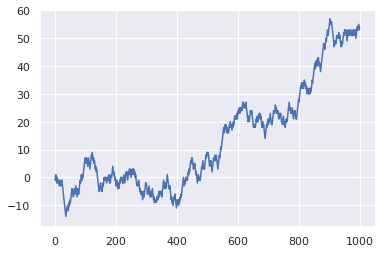

In [ ]:
pyplot.plot(random_walk)
pyplot.show()

11.3 Random Walk and Autocorrelation

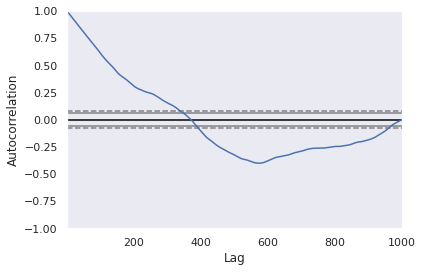

In [ ]:
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
  movement = -1 if random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)
autocorrelation_plot(random_walk)
pyplot.show()

11.4 Random Walk and Stationarity

Therefore we can expect a random walk to be non-stationary. In fact, all random walk
processes are non-stationary. Note that not all non-stationary time series are random walks.
Additionally, a non-stationary time series does not have a consistent mean and/or variance over
time. A review of the random walk line plot might suggest this to be the case. We can confirm
this using a statistical significance test, specifically the Augmented Dickey-Fuller test4.

We can perform this test using the adfuller() function5 in the Statsmodels library. The
complete example is listed below.

In [ ]:
# calculate the stationarity of a random walk
from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller
# generate random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
  movement = -1 if random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)
# statistical test
result = adfuller(random_walk)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

(0.34160454935399814, 0.9791747967918744, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2773.394895844241)
ADF Statistic: 0.341605
p-value: 0.979175
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


The null hypothesis of the test is that the time series is non-stationary. Running the example,
we can see that the test statistic value was 0.341605. This is larger than all of the critical values
at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does
appear to be non-stationary with a low likelihood of the result being a statistical fluke.

We can make the random walk stationary by taking the first difference. That is replacing
each observation as the difference between it and the previous value. Given the way that this
random walk was constructed, we would expect this to result in a time series of -1 and 1 values.
This is exactly what we see. The complete example is listed below

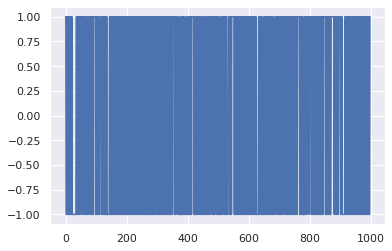

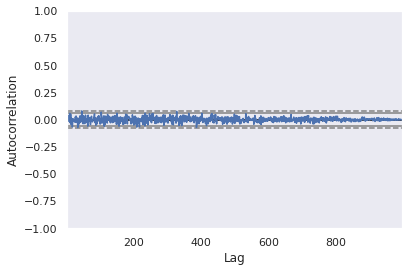

In [ ]:
# calculate and plot a differenced random walk
from random import seed
from random import random
from matplotlib import pyplot
# create random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
  movement = -1 if random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)
# take difference
diff = list()
for i in range(1, len(random_walk)):
  value = random_walk[i] - random_walk[i - 1]
  diff.append(value)
# line plot
pyplot.plot(diff)
pyplot.show()
# line plot
autocorrelation_plot(diff)
pyplot.show()

Running the example, we can see no significant relationship between the lagged observations,
as we would expect from the way the random walk was generated. All correlations are small,
close to zero and below the 95% and 99% confidence levels (beyond a few statistical flukes).

11.5 Predicting a Random Walk

A random walk is unpredictable; it cannot reasonably be predicted. Given the way that the
random walk is constructed, we can expect that the best prediction we could make would be to
use the observation at the previous time step as what will happen in the next time step. Simply
because we know that the next time step will be a function of the prior time step. This is often
called the naive forecast, or a persistence model (covered in Chapter 18).
We can implement this in Python by first splitting the dataset into train and test sets, then
using the persistence model to predict the outcome using a rolling forecast method. Once all
predictions are collected for the test set, the root mean squared error (RMSE) is calculated

In [ ]:
# calculate and plot a differenced random walk
from random import seed
from random import random
from matplotlib import pyplot
# create random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
  movement = -1 if random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]
# persistence
predictions = list()
history = train[-1]
print(train)
print(test)
print(history)
for i in range(len(test)):
  #print(i,'---------------')
  yhat = history
  #print(yhat)
  predictions.append(yhat)
  history = test[i]
  #print(history)
rmse = sqrt(mean_squared_error(test, predictions))
print('Persistence RMSE: %.3f' % rmse)

[-1, 0, 1, 0, -1, -2, -1, 0, -1, -2, -1, -2, -1, -2, -3, -2, -3, -2, -1, -2, -3, -2, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -13, -12, -11, -12, -11, -10, -11, -12, -11, -10, -9, -10, -9, -8, -9, -8, -7, -6, -5, -4, -5, -6, -5, -6, -7, -6, -5, -4, -5, -6, -5, -4, -3, -4, -5, -6, -7, -6, -5, -4, -5, -6, -5, -4, -3, -2, -1, -2, -1, 0, 1, 0, -1, 0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 6, 7, 6, 7, 6, 5, 4, 5, 6, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 7, 8, 9, 8, 7, 6, 7, 6, 5, 6, 5, 4, 3, 4, 3, 2, 3, 2, 1, 0, -1, -2, -3, -4, -5, -4, -3, -4, -3, -2, -3, -4, -5, -4, -5, -4, -3, -2, -3, -2, -1, 0, -1, 0, -1, 0, -1, 0, -1, -2, -1, 0, -1, 0, -1, 0, 1, 0, -1, -2, -1, -2, -1, 0, 1, 0, 1, 2, 3, 4, 3, 2, 1, 2, 1, 0, -1, 0, -1, -2, -3, -2, -1, -2, -3, -4, -3, -2, -3, -4, -3, -2, -1, -2, -1, 0, -1, 0, -1, 0, -1, -2, -1, -2, -1, 0, 1, 0, -1, -2, -1, 0, 1, 2, 1, 2, 1, 0, -1, 0, 1, 2, 1, 2, 3, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 1, 2, 1, 0, 1, 0, -1, -2, -3, -2, -3, -2, -3, -2, -1, -2, 

Another error that beginners to the random walk make is to assume that if the range of
error (variance) is known, then we can make predictions using a random walk generation type
process. That is, if we know the error is either -1 or 1, then why not make predictions by adding
a randomly selected -1 or 1 to the previous value. We can demonstrate this random prediction
method in Python below.

In [ ]:
# calculate and plot a differenced random walk
from random import seed
from random import random
from matplotlib import pyplot
# create random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
  movement = -1 if random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)
# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]
# random prediction
predictions = list()
history = train[-1]
for i in range(len(test)):
  yhat = history + (-1 if random() < 0.5 else 1)
  predictions.append(yhat)
  history = test[i]
rmse = sqrt(mean_squared_error(test, predictions))
print('Random RMSE: %.3f' % rmse)

Random RMSE: 1.328


Your time series may be a random walk. Some ways to check if your time series is a random
walk are as follows:

 The time series shows a strong temporal dependence that decays linearly or in a similar
pattern.

 The time series is non-stationary and making it stationary shows no obviously learnable
structure in the data.

 The persistence model provides the best source of reliable predictions

# Chapter 12 Decompose Time Series Data

 Systematic: Components of the time series that have consistency or recurrence and can
be described and modeled.

 Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level,
trend, seasonality, and one non-systematic component called noise. These components are
defined as follows:

 Level: The average value in the series.

 Trend: The increasing or decreasing value in the series.

 Seasonality: The repeating short-term cycle in the series.

 Noise: The random variation in the series.

12.4 Automatic Time Series Decomposition

[4, 9, 3, 8, 14, 15, 8, 17, 14, 17, 15, 21, 13, 14, 20, 18, 19, 19, 20, 26, 30, 25, 26, 32, 33, 32, 28, 31, 35, 38, 33, 41, 37, 34, 36, 39, 46, 44, 46, 48, 50, 45, 47, 44, 47, 54, 55, 51, 55, 54, 57, 58, 57, 61, 56, 58, 59, 66, 59, 67, 61, 69, 66, 70, 73, 71, 70, 69, 70, 70, 77, 79, 76, 76, 84, 84, 80, 86, 85, 88, 86, 85, 86, 89, 94, 87, 92, 88, 96, 90, 100, 94, 95, 98, 102, 96, 106, 106, 100]


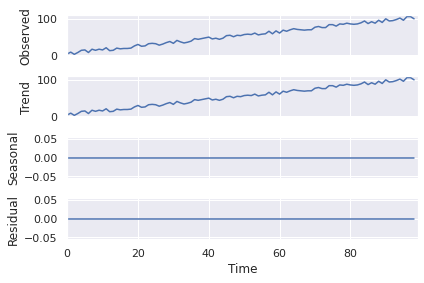

In [ ]:
# additive decompose a contrived additive time series
from random import randrange
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
print(series)
result = seasonal_decompose(series, model='additive', freq=1)
print(result)
result.plot()
pyplot.show()

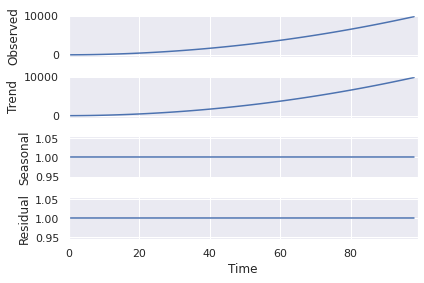

In [ ]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i**2.0 for i in range(1,100)]
result = seasonal_decompose(series, model='multiplicative', freq=1)
result.plot()
pyplot.show()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64


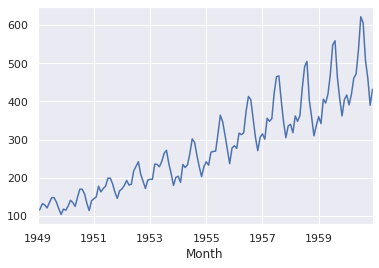

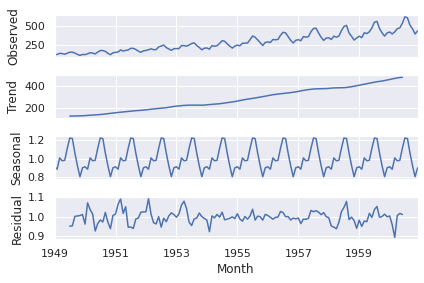

In [ ]:
# multiplicative decompose time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
print(series)
series.plot()
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

Running the example plots the observed, trend, seasonal, and residual time series. We can
see that the trend and seasonality information extracted from the series does seem reasonable.
The residuals are also interesting, showing periods of high variability in the early and later years
of the series.

# Chapter 13 Use and Remove Trends

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5 342.3
 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3 646.9]
[-120.1, 37.19999999999999, -63.8, 61.000000000000014, -11.800000000000011, 63.30000000000001, -7.300000000000011, -31.69999999999999, -69.9, 213.6, -150.6, 8.400000000000006, -44.80000000000001, 60.599999999999994, 63.20000000000002, -81.9, 95.6, -61.0, 77.60000000000002, -13.700000000000045, 131.70000000000005, -157.10000000000002, 77.80000000000001, -2.6000000000000227, 100.69999999999999, -124.5, 123.40000000000003, -38.0, 36.099999999999966, 138.10000000000002, -167.89999999999998, 274.4, -206.7, 105.99999999999994, 65.60000000000002]


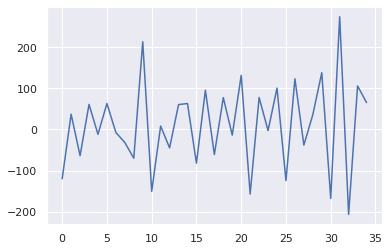

In [ ]:
# detrend a time series using differencing
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True, date_parser=parser)
X = series.values
print(X)
diff = list()
for i in range(1, len(X)):
  value = X[i] - X[i - 1]
  diff.append(value)
print(diff)
pyplot.plot(diff)
pyplot.show()
# Lấy giá trị sau trừ giá trị trước

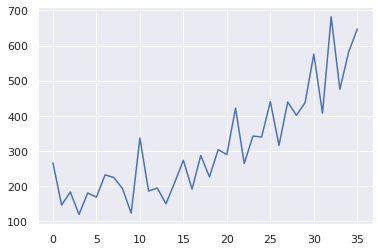

In [ ]:
pyplot.plot(X)

The predictions from this model will form a straight line that can be taken as the trend
line for the dataset. These predictions can also be subtracted from the original time series to
provide a detrended version of the dataset.
value(t) = observation(t) − prediction(t) (13.2)
The residuals from the fit of the model are a detrended form of the dataset. Polynomial
curve fitting and other nonlinear models can also be used. We can implement this in Python by
training a scikit-learn LinearRegression model1 on the data.

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]]
[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5 342.3
 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3 646.9]


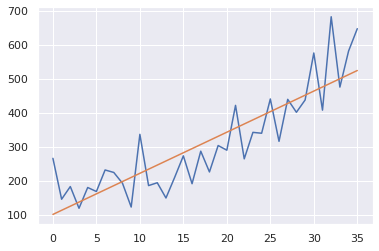

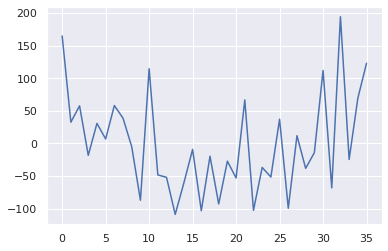

In [ ]:
# use a linear model to detrend a time series
from pandas import read_csv
from pandas import datetime
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy

# fit linear model
X = [i for i in range(0, len(series))]
X = numpy.reshape(X, (len(X), 1))
y = series.values
print(X)
print(y)
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
pyplot.plot(y)
pyplot.plot(trend)
pyplot.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
pyplot.plot(detrended)
pyplot.show()
# Dùng Linear regression predict y theo x, sau đó vẽ trend
# Detrend bằng cách lấy giá trị thưc tế trừ giá trị predict

# Chapter 14 Use and Remove Seasonality

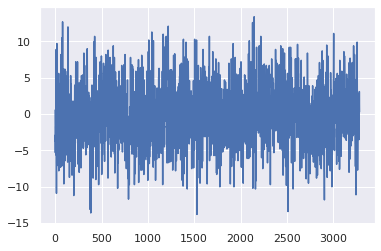

In [ ]:
# deseasonalize a time series using differencing
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True)
X = series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
  value = X[i] - X[i - days_in_year]
  diff.append(value)
pyplot.plot(diff)
pyplot.show()
# Lấy dữ liệu của năm này trừ cho dữ liệu của nó vào năm ngoáitìm diff

Date
1981-01-31    17.712903
1981-02-28    17.678571
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
1981-06-30     7.306667
1981-07-31     7.577419
1981-08-31     7.238710
1981-09-30    10.143333
1981-10-31    10.087097
1981-11-30    11.890000
1981-12-31    13.680645
1982-01-31    16.567742
Freq: M, Name: Temp, dtype: float64


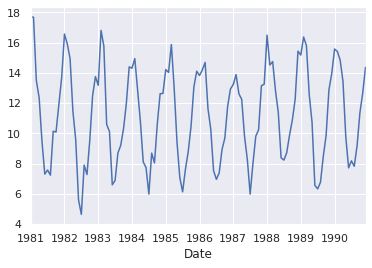

In [ ]:
# deseasonalize a time series using differencing
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True)
resample = series.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(13))
monthly_mean.plot()
pyplot.show()
# Dữ liệu mean hàng tháng

Date
1981-01-31    17.712903
1981-02-28    17.678571
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
                ...    
1990-08-31     7.825806
1990-09-30     9.166667
1990-10-31    11.345161
1990-11-30    12.656667
1990-12-31    14.367742
Freq: M, Name: Temp, Length: 120, dtype: float64
120
[20.7 17.9 18.8 ... 13.5 15.7 13. ]


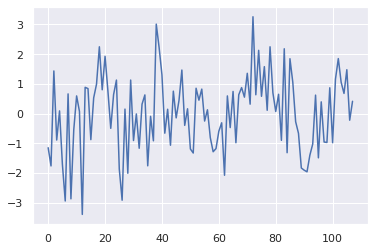

In [ ]:
resample = series.resample('M')
monthly_mean = resample.mean()
monthly_mean.to_csv('montly_mean.csv')
print(monthly_mean)
print(len(monthly_mean))
X = series.values
print(X)
diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
  #print(i)
  #print(monthly_mean[i])
  #print(monthly_mean[i - months_in_year])
  value = monthly_mean[i] - monthly_mean[i - months_in_year]
  #print(value)
  diff.append(value)
pyplot.plot(diff)
pyplot.show()
# Lấy dữ liệu của tháng này trừ dữ liệu của nó vào năm ngoái

Running the example creates a new seasonally adjusted monthly minimum temperature
dataset, skipping the first year of data in order to create the adjustment. The adjusted dataset
is then plotted.

Next, we can use the monthly average minimum temperatures from the same month in the
previous year to adjust the daily minimum temperature dataset. Again, we just skip the first
year of data, but the correction using the monthly rather than the daily data may be a more
stable approach

        i_ month_str_  month_mean_last_year_    X_      diff
0      365     1981-1              17.712903  17.0 -0.712903
1      366     1981-1              17.712903  15.0 -2.712903
2      367     1981-1              17.712903  13.5 -4.212903
3      368     1981-1              17.712903  15.2 -2.512903
4      369     1981-1              17.712903  13.0 -4.712903
...    ...        ...                    ...   ...       ...
3280  3645    1989-12              13.951613  14.0  0.048387
3281  3646    1989-12              13.951613  13.6 -0.351613
3282  3647    1989-12              13.951613  13.5 -0.451613
3283  3648    1989-12              13.951613  15.7  1.748387
3284  3649    1989-12              13.951613  13.0 -0.951613

[3285 rows x 5 columns]


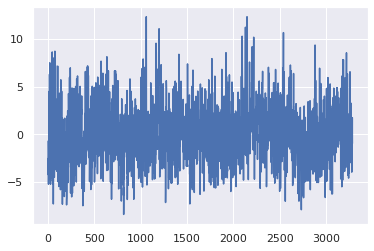

In [ ]:
X = series.values
diff = list()
month_str_=list()
month_mean_last_year_=list()
i_=list()
X_=list()
days_in_year = 365
for i in range(days_in_year, len(X)):
  month_str = str(series.index[i].year-1)+'-'+str(series.index[i].month)
  month_mean_last_year = series[month_str].mean()
  value = X[i] - month_mean_last_year
  diff.append(value)
  month_str_.append(month_str)
  month_mean_last_year_.append(month_mean_last_year)
  i_.append(i)
  X_.append(X[i])
i_=Series(i_)
month_str_=Series(month_str_)
month_mean_last_year_=Series(month_mean_last_year_)
X_=Series(X_)
diff=Series(diff)
#values = pd.DataFrame(series.values)
dataframe = pd.concat([i_,month_str_,month_mean_last_year_,X_,diff], axis=1)
dataframe.columns = ['i_', 'month_str_','month_mean_last_year_','X_','diff']
dataframe.to_excel('temp_transform.xlsx')
print(dataframe)
pyplot.plot(diff)
pyplot.show()
# Lấy giá trị temp daily sau 1 năm trừ cho giá trị temp average của tháng chứa ngày đó vào năm ngoái

14.4 Seasonal Adjustment with Modeling

3650
X [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

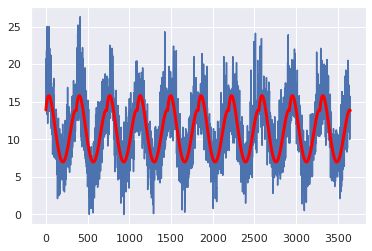

In [ ]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
print(len(series))
print("X",X)
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
  value = coef[-1]
  for d in range(degree):
    value += X[i]**(degree-d) * coef[d]
  curve.append(value)
  # y = (x^4 × b1) + (x^3 × b2) + (x^2 × b3) + (x^1 × b4) + b5
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()
# Tính giá trị y dựa trên hàm poly từ x

3650
X [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

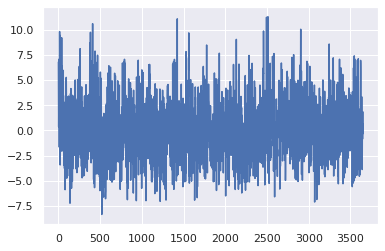

In [ ]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
print(len(series))
print("X",X)
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
  value = coef[-1]
  for d in range(degree):
    value += X[i]**(degree-d) * coef[d]
  curve.append(value)
  # y = (x^4 × b1) + (x^3 × b2) + (x^2 × b3) + (x^1 × b4) + b5
# create seasonally adjusted
values = series.values
diff = list()
for i in range(len(values)):
  value = values[i] - curve[i]
  diff.append(value)
pyplot.plot(diff)
pyplot.show()
# Lấy giá trị thực trừ cho giá trị prediction theo từng ngày

# Chapter 15 Stationarity in Time Series Data

Time series is different from more traditional classification and regression predictive modeling
problems. The temporal structure adds an order to the observations. This imposed order means
that important assumptions about the consistency of those observations needs to be handled
specifically. For example, when modeling, there are assumptions that the summary statistics of
observations are consistent. In time series terminology, we refer to this expectation as the time
series being stationary. These assumptions can be easily violated in time series by the addition
of a trend, seasonality, and other time-dependent structures. In this tutorial, you will discover
how to check if your time series is stationary with Python. After completing this tutorial, you
will know:

15.1 Stationary Time Series

The observations in a stationary time series are not dependent on time. Time series are stationary
if they do not have trend or seasonal effects. Summary statistics calculated on the time series
are consistent over time, like the mean or the variance of the observations. When a time series
is stationary, it can be easier to model. Statistical modeling methods assume or require the
time series to be stationary to be effective. Below is an example of the Daily Female Births
dataset that is stationary. You can learn more about the dataset in Appendix A.4.

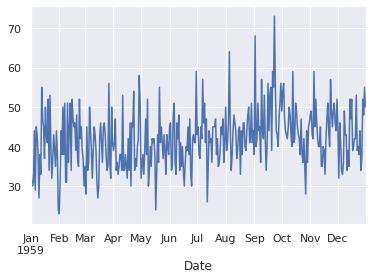

In [ ]:
# load time series data
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
series.plot()
pyplot.show()

15.2 Non-Stationary Time Series

Observations from a non-stationary time series show seasonal effects, trends, and other structures
that depend on the time index. Summary statistics like the mean and variance do change over
time, providing a drift in the concepts a model may try to capture. Classical time series analysis
and forecasting methods are concerned with making non-stationary time series data stationary
by identifying and removing trends and removing seasonal effects. Below is an example of the
Airline Passengers dataset that is non-stationary, showing both trend and seasonal components.
You can learn more about the dataset in Appendix A.5.

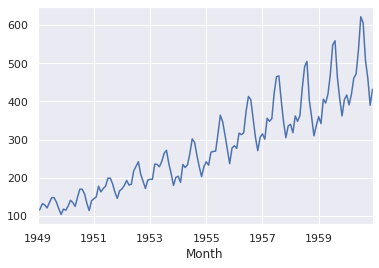

In [ ]:
# load time series data
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
series.plot()
pyplot.show()

15.6 Summary Statistics

Daily Births Dataset

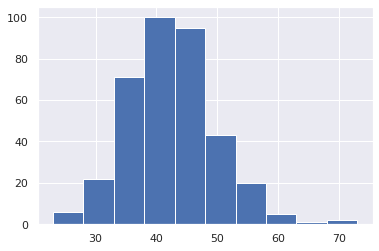

In [ ]:
# load time series data
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
series.hist()
pyplot.show()

In [ ]:
X = series.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=39.763736, mean2=44.185792
variance1=49.213410, variance2=48.708651


Running this example shows that the mean and variance values are different, but in the
same ball-park.

Airline Passengers Dataset

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
X = series.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=182.902778, mean2=377.694444
variance1=2244.087770, variance2=7367.962191


Running the example, we can see the mean and variance look very different. We have a
non-stationary time series.

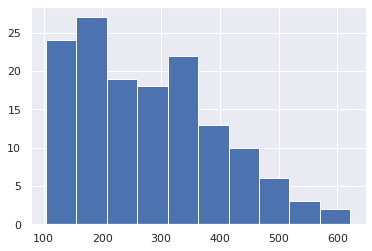

In [ ]:
series.hist()
pyplot.show()

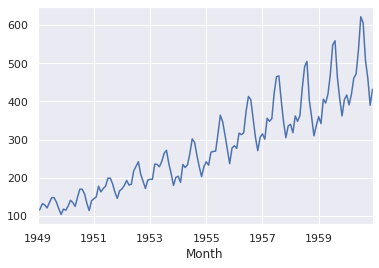

In [ ]:
series.plot()

Running the example shows that indeed the distribution of values does not look like a
Gaussian, therefore the mean and variance values are less meaningful. This squashed distribution
of the observations may be another indicator of a non-stationary time series.

Reviewing the plot of the time series again, we can see that there is an obvious seasonality
component, and it looks like the seasonality component is growing. This may suggest an
exponential growth from season to season. A log transform can be used to flatten out exponential
change back to a linear relationship. Below is the same histogram with a log transform of the
time series.

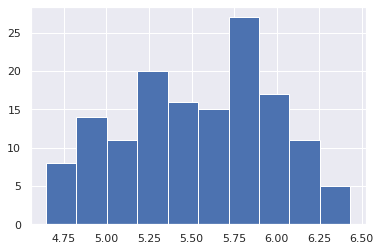

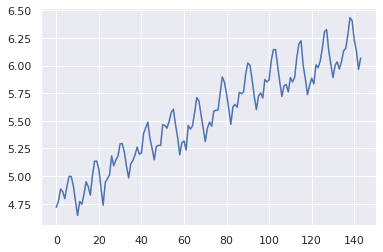

In [ ]:
from numpy import log
X = series.values
X = log(X)
pyplot.hist(X)
pyplot.show()
pyplot.plot(X)
pyplot.show()

Running the example, we can see the more familiar Gaussian-like or Uniform-like distribution
of values.

In [ ]:
X = series.values
X = log(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5.175146, mean2=5.909206
variance1=0.068375, variance2=0.049264


Running the examples shows mean and standard deviation values for each group that are
again similar, but not identical. Perhaps, from these numbers alone, we would say the time
series is stationary, but we strongly believe this to not be the case from reviewing the line plot.

This is a quick and dirty method that may be easily fooled. We can use a statistical test to
check if the difference between two samples of Gaussian random variables is real or a statistical
fluke. We could explore statistical significance tests, like the Student’s t-test, but things get
tricky because of the serial correlation between values. In the next section, we will use a
statistical test designed to explicitly comment on whether a univariate time series is stationary.

15.7 Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test1. The
intuition behind a unit root test is that it determines how strongly a time series is defined by a
trend.
There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the
more widely used. It uses an autoregressive model and optimizes an information criterion across
multiple different lag values. The null hypothesis of the test is that the time series can be
represented by a unit root, that it is not stationary (has some time-dependent structure). The
alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary

In [ ]:
# load time series data
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Running the example prints the test statistic value of -4. The more negative this statistic,
the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of
the output, we get a look-up table to help determine the ADF statistic. We can see that our
statistic value of -4 is less than the value of -3.449 at 1%.
This suggests that we can reject the null hypothesis with a significance level of less than 1%
(i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means
that the process has no unit root, and in turn that the time series is stationary or does not have
time-dependent structure

In [ ]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Running the example gives a different picture than the above. The test statistic is positive,
meaning we are much less likely to reject the null hypothesis (it looks non-stationary). Comparing
the test statistic to the critical values, it looks like we would have to fail to reject the null
hypothesis that the time series is non-stationary and does have time-dependent structure.

In [ ]:
# calculate stationarity test of log transformed time series data
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from numpy import log
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
X = series.values
X=log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Running the example shows a negative value for the test statistic. We can see that the value
is larger than the critical values, again, meaning that we fail to reject the null hypothesis and in
turn that the time series is non-stationary.

# IV- Evaluate models

# Chapter 16 Backtest Forecast Models

In this lesson, we will use the Monthly Sunspots dataset as an example. This dataset describes
a monthly count of the number of observed sunspots for just over 230 years (1749-1983). You
can learn more about the dataset in Appendix A.3. Place the dataset in your current working
directory with the filename sunspots.csv.

16.3 Train-Test Split

Observations: 2820
Training Observations: 1861
Testing Observations: 959


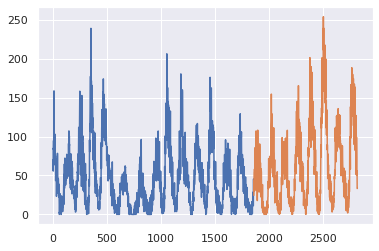

In [ ]:
# calculate a train-test split of a time series dataset
from pandas import read_csv
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

Using a train-test split method to evaluate machine learning models is fast. Preparing the
data is simple and intuitive and only one model is created and evaluated. It is useful when
you have a large amount of data so that both training and tests sets are representative of the
original problem. Next, we will look at repeating this process multiple times.

16.4 Multiple Train-Test Splits

Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


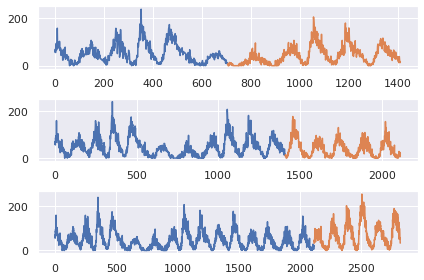

In [ ]:
# calculate repeated train-test splits of time series data
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
  train = X[train_index]
  test = X[test_index]
  print('Observations: %d' % (len(train) + len(test)))
  print('Training Observations: %d' % (len(train)))
  print('Testing Observations: %d' % (len(test)))
  pyplot.subplot(310 + index)
  pyplot.plot(train)
  pyplot.plot([None for i in train] + [x for x in test])
  index += 1
pyplot.tight_layout()
pyplot.show()

Using multiple train-test splits will result in more models being trained, and in turn, a
more accurate estimate of the performance of the models on unseen data. A limitation of the
train-test split approach is that the trained models remain fixed as they are evaluated on each
evaluation in the test set. This may not be realistic as models can be retrained as new daily or
monthly observations are made available. This concern is addressed in the next section.

16.5 Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available. This would
give the model the best opportunity to make good forecasts at each time step. We can evaluate
our machine learning models under this assumption. There are few decisions to make:

1. Minimum Number of Observations. First, we must select the minimum number of
observations required to train the model. This may be thought of as the window width if
a sliding window is used (see next point).

2. Sliding or Expanding Window. Next, we need to decide whether the model will
be trained on all data it has available or only on the most recent observations. This
determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and
evaluated.

1. Starting at the beginning of the time series, the minimum number of samples in the
window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to
step 1.)

In [ ]:
X = series.values
n_train = 500
n_records = len(X)
for i in range(n_train, n_records):
  train, test = X[0:i], X[i:i+1]
  print('train=%d, test=%d' % (len(train), len(test)))

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521, test=1
train=522, test=1
train=523, test=1
train=524, test=1
train=525, test=1
train=526, test=1
train=527, test=1
train=528, test=1
train=529, test=1
train=530, test=1
train=531, test=1
train=532, test=1
train=533, test=1
train=534, test=1
train=535, test=1
train=536, test=1
train=537, test=1
train=538, test=1
train=539, test=1
train=540, test=1
train=541, test=1
train=542, test=1
train=543, test=1
train=544, test=1
train=545, test=1
train=546, test=1
train=547, test=1
train=548, test=1
train=549, test=1
train=550, test=1
train=551, test=1
train=552, test=1
train=553, test=1
train=554, test=1
train=555,

# Chapter 17 Forecasting Performance Measures

In [ ]:
# calculate forecast error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [-0.2, 0.09999999999999998, -0.1, -0.09999999999999998, -0.2]


In [ ]:
# calculate mean forecast error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f' % bias)

Bias: -0.100000


In [ ]:
# calculate mean absolute error
from sklearn.metrics import mean_absolute_error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mae = mean_absolute_error(expected, predictions)
print('MAE: %f' % mae)

MAE: 0.140000


In [ ]:
# calculate mean squared error
from sklearn.metrics import mean_squared_error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 0.022000


In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.148324


# Chapter 18 Persistence Model for Forecasting

18.1 Forecast Performance Baseline

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

       t    t+1
0    NaN  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [ ]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model
def model_persistence(x):
  return x

In [ ]:
# walk-forward validation
predictions = list()
for x in test_X:
  yhat = model_persistence(x)
  #yhat=x
  predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 133.156


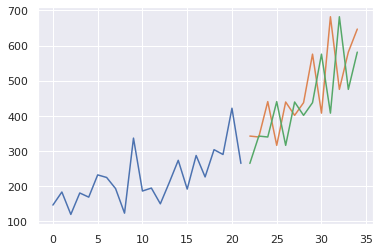

In [ ]:
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

Full

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()


       t    t+1
0    NaN  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3
Test RMSE: 133.156


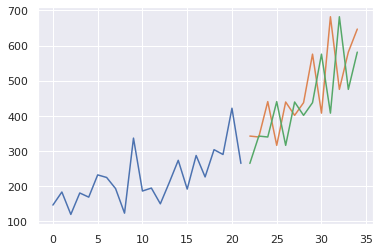

In [ ]:
# evaluate a persistence forecast model
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
  return x
# walk-forward validation
predictions = list()
for x in test_X:
  yhat = model_persistence(x)
  predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

# Chapter 19 Visualize Residual Forecast Errors

[51. 41. 44. 38. 68. 40. 42. 51. 44. 45. 36. 57. 44. 42. 53. 42. 34. 40.
 56. 44. 53. 55. 39. 59. 55. 73. 55. 44. 43. 40. 47. 51. 56. 49. 54. 56.
 47. 44. 43. 42. 45. 50. 48. 43. 40. 59. 41. 42. 51. 49. 45. 43. 42. 38.
 47. 38. 36. 42. 35. 28. 44. 36. 45. 46. 48. 49. 43. 42. 59. 45. 52. 46.
 42. 40. 40. 45. 35. 35. 40. 39. 33. 42. 47. 51. 44. 40. 57. 49. 45. 49.
 51. 46. 44. 52. 45. 32. 46. 41. 34. 33. 36. 49. 43. 43. 34. 39. 35. 52.
 47. 52. 39. 40. 42. 42. 53. 39. 40. 38. 44. 34. 37. 52. 48. 55. 50.]
[42.0, 51.0, 41.0, 44.0, 38.0, 68.0, 40.0, 42.0, 51.0, 44.0, 45.0, 36.0, 57.0, 44.0, 42.0, 53.0, 42.0, 34.0, 40.0, 56.0, 44.0, 53.0, 55.0, 39.0, 59.0, 55.0, 73.0, 55.0, 44.0, 43.0, 40.0, 47.0, 51.0, 56.0, 49.0, 54.0, 56.0, 47.0, 44.0, 43.0, 42.0, 45.0, 50.0, 48.0, 43.0, 40.0, 59.0, 41.0, 42.0, 51.0, 49.0, 45.0, 43.0, 42.0, 38.0, 47.0, 38.0, 36.0, 42.0, 35.0, 28.0, 44.0, 36.0, 45.0, 46.0, 48.0, 49.0, 43.0, 42.0, 59.0, 45.0, 52.0, 46.0, 42.0, 40.0, 40.0, 45.0, 35.0, 35.0, 40.0, 39.0, 33.0,

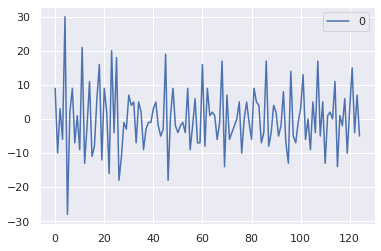

                0
count  125.000000
mean     0.064000
std      9.187776
min    -28.000000
25%     -6.000000
50%     -1.000000
75%      5.000000
max     30.000000


In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(test_y)
print(predictions)
print(residuals.head())
# plot residuals
residuals.plot()
pyplot.show()
# summary statistics
print(residuals.describe())

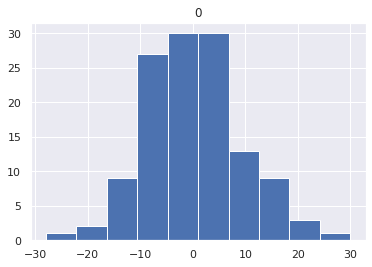

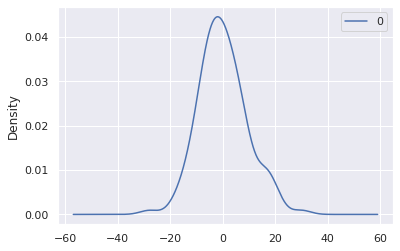

In [ ]:
# histogram plot
residuals.hist()
pyplot.show()
# density plot
residuals.plot(kind='kde')
pyplot.show()

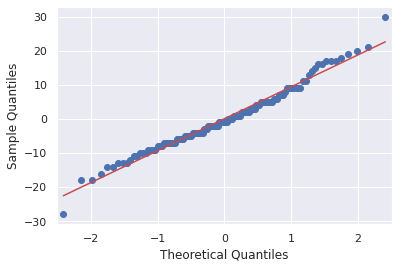

In [ ]:
from statsmodels.graphics.gofplots import qqplot
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = numpy.array(residuals)
qqplot(residuals, line='r')
pyplot.show()

Running the example shows a Q-Q plot that the distribution is seemingly normal with a few
bumps and outliers

19.8 Residual Autocorrelation Plot

Autocorrelation calculates the strength of the relationship between an observation and observations at prior time steps. We can calculate the autocorrelation of the residual error time series
and plot the results. This is called an autocorrelation plot. We would not expect there to be
any correlation between the residuals. This would be shown by autocorrelation scores being
below the threshold of significance (dashed and dotted horizontal lines on the plot).
A significant autocorrelation in the residual plot suggests that the model could be doing
a better job of incorporating the relationship between observations and lagged observations,
called autoregression. Pandas provides a built-in function for calculating an autocorrelation
plot, called autocorrelation plot().

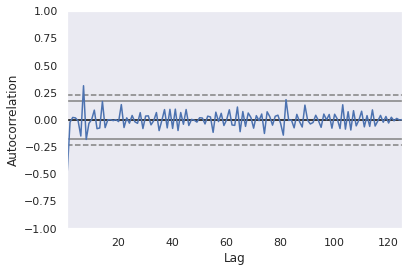

In [ ]:
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
autocorrelation_plot(residuals)
pyplot.show()

Running the example creates an autoregression plot of other residual errors. We do not see
an obvious autocorrelation trend across the plot. There may be some positive autocorrelation
worthy of further investigation at lag 7 that seems significant.

# Chapter 20 Reframe Time Series Forecasting Problems

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


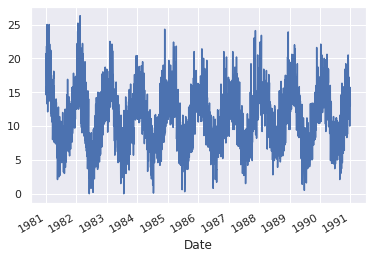

In [ ]:
file='https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/daily-temp.csv'
series = read_csv(file, header=0, index_col=0,parse_dates=True, squeeze=True)
print(series.head())
series.plot()

Regression Framings

 Forecast the change in the minimum temperature compared to the previous day.

 Forecast the minimum temperature relative to the average from the past 14 days.

 Forecast the minimum temperature relative to the average the same month last year.

In [ ]:
# create lagged dataset
values = DataFrame(series.values)
print(values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# round forecast to nearest 5
for i in range(len(dataframe['t+1'])):
  dataframe['t+1'][i] = int(dataframe['t+1'][i] / 5) * 5.0
print(dataframe.head(5))
# Forecast the minimum temperature rounded to the nearest 5 degrees Celsius

         0
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
3645  14.0
3646  13.6
3647  13.5
3648  15.7
3649  13.0

[3650 rows x 1 columns]
      t   t+1
0   NaN  20.0
1  20.7  15.0
2  17.9  15.0
3  18.8  10.0
4  14.6  15.0


Classification Framings

 Forecast whether a minimum temperature will be cold, moderate, or warm.

 Forecast whether a change in minimum temperature will be small or large.

 Forecast whether the minimum temperature will be a monthly minimum or not.

 Forecast whether the minimum will be higher or lower than the minimum in the previous
year.

 Forecast whether the minimum temperature will rise or fall over the next 7 days.

In [ ]:
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# make discrete
for i in range(len(dataframe['t+1'])):
  value = dataframe['t+1'][i]
  if value < 10.0:
    dataframe['t+1'][i] = 0
  elif value >= 25.0:
    dataframe['t+1'][i] = 2
  else:
    dataframe['t+1'][i] = 1
print(dataframe)

         t  t+1
0      NaN  1.0
1     20.7  1.0
2     17.9  1.0
3     18.8  1.0
4     14.6  1.0
...    ...  ...
3645  14.6  1.0
3646  14.0  1.0
3647  13.6  1.0
3648  13.5  1.0
3649  15.7  1.0

[3650 rows x 2 columns]


Time Horizon Framings

 Forecast the minimum temperature for the next 7 days.

 Forecast the minimum temperature in 30 days time.

 Forecast the average minimum temperature next month.

 Forecast the day in the next week that will have the lowest minimum temperature.

 Forecast one year of minimum temperature values

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values, values.shift(-1),
            values.shift(-2), values.shift(-3), values.shift(-4), values.shift(-5),
            values.shift(-6)], axis=1)
dataframe.columns = ['t', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7']
print(dataframe.head(14))

       t   t+1   t+2   t+3   t+4   t+5   t+6   t+7
0    NaN  20.7  17.9  18.8  14.6  15.8  15.8  15.8
1   20.7  17.9  18.8  14.6  15.8  15.8  15.8  17.4
2   17.9  18.8  14.6  15.8  15.8  15.8  17.4  21.8
3   18.8  14.6  15.8  15.8  15.8  17.4  21.8  20.0
4   14.6  15.8  15.8  15.8  17.4  21.8  20.0  16.2
5   15.8  15.8  15.8  17.4  21.8  20.0  16.2  13.3
6   15.8  15.8  17.4  21.8  20.0  16.2  13.3  16.7
7   15.8  17.4  21.8  20.0  16.2  13.3  16.7  21.5
8   17.4  21.8  20.0  16.2  13.3  16.7  21.5  25.0
9   21.8  20.0  16.2  13.3  16.7  21.5  25.0  20.7
10  20.0  16.2  13.3  16.7  21.5  25.0  20.7  20.6
11  16.2  13.3  16.7  21.5  25.0  20.7  20.6  24.8
12  13.3  16.7  21.5  25.0  20.7  20.6  24.8  17.7
13  16.7  21.5  25.0  20.7  20.6  24.8  17.7  15.5


# V- Forecast Models

# Chap 22 Autoregression Model

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


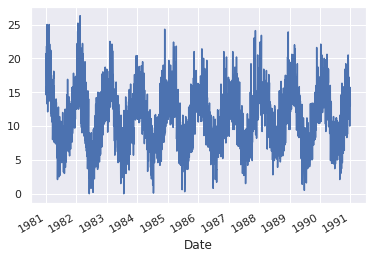

In [ ]:
file='https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/daily-temp.csv'
series = read_csv(file, header=0, index_col=0,parse_dates=True, squeeze=True)
print(series.head())
series.plot()

Quick Check for Autocorrelation

There is a quick, visual check that we can do to see if there is an autocorrelation in our time
series dataset. We can plot the observation at the current time step (t) with the observation at
the previous time step (t-1) as a scatter plot. This could be done manually by first creating a
lag version of the time series dataset and using a built-in scatter plot function in the Pandas
library. But there is an easier way.
Pandas provides a built-in plot to do exactly this, called the lag plot() function1. Below is
an example of creating a lag plot of the Minimum Daily Temperatures dataset.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


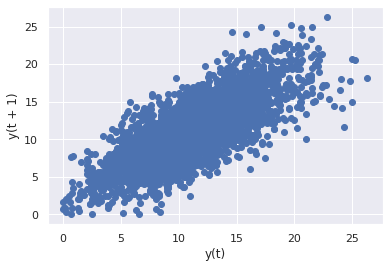

In [ ]:
lag_plot(series)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


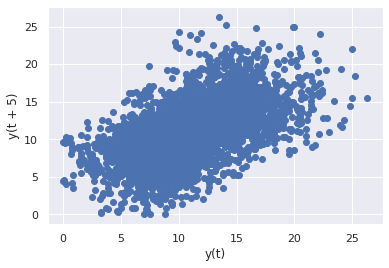

In [ ]:
lag_plot(series,lag=5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


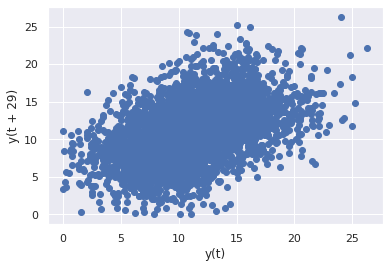

In [ ]:
lag_plot(series,lag=29)

We can see a large ball of observations along a diagonal line of the plot. It clearly shows a
relationship or some correlation. This process could be repeated for any other lagged observation,
such as if we wanted to review the relationship with the last 7 days or with the same day last
month or last year. Another quick check that we can do is to directly calculate the correlation
between the observation and the lag variable.
We can use a statistical test like the Pearson’s correlation coefficient. This produces a
number to summarize how correlated two variables are between -1 (negatively correlated) and
+1 (positively correlated) with small values close to zero indicating low correlation and high
values above 0.5 or below -0.5 showing high correlation.
Correlation can be calculated easily using the corr() function2 on the DataFrame of the
lagged dataset. The example below creates a lagged version of the Minimum Daily Temperatures
dataset and calculates a correlation matrix of each column with other columns, including itself.

In [ ]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe

t   t+1
0      NaN  20.7
1     20.7  17.9
2     17.9  18.8
3     18.8  14.6
4     14.6  15.8
...    ...   ...
3645  14.6  14.0
3646  14.0  13.6
3647  13.6  13.5
3648  13.5  15.7
3649  15.7  13.0

[3650 rows x 2 columns]

In [ ]:
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


In [ ]:
lag=25
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
dataframe.corr()

t      t+25
t     1.000000  0.506421
t+25  0.506421  1.000000

In [ ]:
lag=50
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
dataframe.corr()

t      t+50
t     1.000000  0.346891
t+50  0.346891  1.000000

In [ ]:
lag=3500
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t', 't+'+str(lag)]
dataframe.corr()

t   t+3500
t       1.00000 -0.40764
t+3500 -0.40764  1.00000

Autocorrelation Plots

We can plot the correlation coefficient for each lag variable. This can very quickly give an
idea of which lag variables may be good candidates for use in a predictive model and how
the relationship between the observation and its historic values changes over time. We could
manually calculate the correlation values for each lag variable and plot the result. Thankfully,
Pandas provides a built-in plot called the autocorrelation plot() function3.
The plot provides the lag number along the x-axis and the correlation coefficient value
between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the
95% and 99% confidence interval for the correlation values. Correlation values above these lines
are more significant than those below the line, providing a threshold or cutoff for selecting more
relevant lag values.

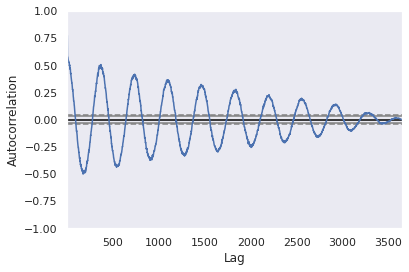

In [ ]:
autocorrelation_plot(series)
plt.show()

Running the example shows the swing in positive and negative correlation as the temperature
values change across summer and winter seasons each previous year

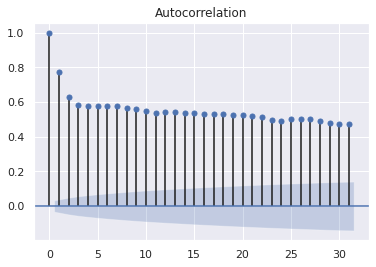

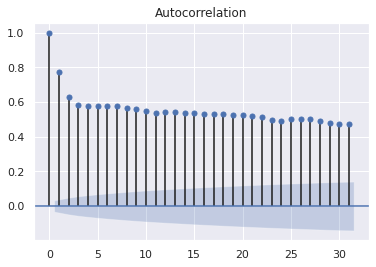

In [ ]:
plot_acf(series, lags=31)

Persistence Model

We can develop a test harness for the problem by splitting the observations into training
and test sets, with only the last 7 observations in the dataset assigned to the test set as unseen
data that we wish to predict. The predictions are made using a walk-forward validation model
so that we can persist the most recent observations for the next day. This means that we are
not making a 7-day forecast, but 7 1-day forecasts.

In [ ]:
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head()

t   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8

In [ ]:
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
print(train.shape)
print(test.shape)

(3642, 2)
(7, 2)


In [ ]:
train

array([[20.7, 17.9],
       [17.9, 18.8],
       [18.8, 14.6],
       ...,
       [13.1, 13.2],
       [13.2, 13.9],
       [13.9, 10. ]])

In [ ]:
test

array([[10. , 12.9],
       [12.9, 14.6],
       [14.6, 14. ],
       [14. , 13.6],
       [13.6, 13.5],
       [13.5, 15.7],
       [15.7, 13. ]])

In [ ]:
# persistence model
def model_persistence(x):
  return x

In [ ]:
# walk-forward validation
predictions = list()
for x in test_X:
  yhat = model_persistence(x)
  predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.850


In [ ]:
test_X # = yhat

array([10. , 12.9, 14.6, 14. , 13.6, 13.5, 15.7])

In [ ]:
test_y # text_y = text_x +1 day (past predict future)

array([12.9, 14.6, 14. , 13.6, 13.5, 15.7, 13. ])

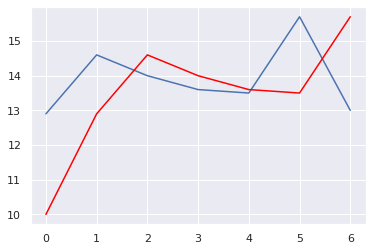

In [ ]:
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

22.7 Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.
We could calculate the linear regression model manually using the LinearRegession class in
scikit-learn and manually specify the lag input variables to use. Alternately, the Statsmodels
library provides an autoregression model that automatically selects an appropriate lag value
using statistical tests and trains a linear regression model. It is provided in the AR class5.

We can use this model by first creating the model AR() and then calling fit() to train it
on our dataset. This returns an ARResult object6. Once fit, we can use the model to make a
prediction by calling the predict() function for a number of observations in the future. This
creates 1 7-day forecast, which is different from the persistence example above. The complete
example is listed below.

In [ ]:
# train autoregression
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train

array([17.9, 18.8, 14.6, ..., 13.2, 13.9, 10. ])

In [ ]:
test

array([12.9, 14.6, 14. , 13.6, 13.5, 15.7, 13. ])

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


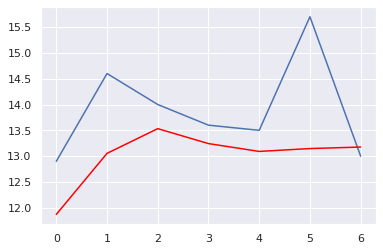

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

file='https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/daily-temp.csv'
series = read_csv(file, header=0, index_col=0,parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
  print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# Tu dong predict 7 ngay sau ma khong can du lieu moi, tu lay 29 du lieu cu tien doan
# nhung gia tri tiep theo

Running the example first prints the chosen optimal lag and the list of coefficients in the
trained linear regression model. We can see that a 29-lag model was chosen and trained. This is
interesting given how close this lag is to the average number of days in a month. The 7 day
forecast is then printed and the root mean squared error of the forecast is summarized

The Statsmodels API does not make it easy to update the model as new observations become
available. One way would be to re-train the AR model each day as new observations become
available, and that may be a valid approach, if not computationally expensive. An alternative
would be to use the learned coefficients and manually make predictions. This requires that the
history of 29 prior observations be kept and that the coefficients be retrieved from the model
and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients
for each lag variable starting at t to t-n. We simply need to use them in the right order on the
history of observations, as follows:

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


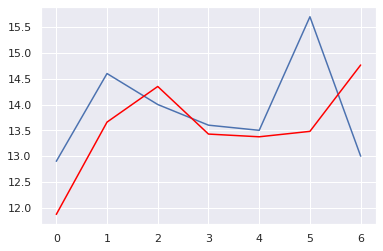

In [ ]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

file='https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/daily-temp.csv'
series = read_csv(file, header=0, index_col=0,parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:] # 29 du lieu gan nhat cua train dung cho predict test
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  yhat = coef[0]
  for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Explain

window 29
coef [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
history [12.9, 8.8, 14.7, 14.7, 12.7, 13.3, 13.2, 16.2, 17.3, 20.5, 20.2, 19.4, 15.5, 14.1, 11.0, 11.1, 14.0, 11.4, 12.5, 13.4, 13.6, 13.9, 17.2, 14.7, 15.4, 13.1, 13.2, 13.9, 10.0]
0 -----------for 1
length 29
lag [12.9, 8.8, 14.7, 14.7, 12.7, 13.3, 13.2, 16.2, 17.3, 20.5, 20.2, 19.4, 15.5, 14.1, 11.0, 11.1, 14.0, 11.4, 12.5, 13.4, 13.6, 13.9, 17.2, 14.7, 15.4, 13.1, 13.2, 13.9, 10.0]
yhat 0.5575435064290549
0 for 2
coef[d+1] 0.5885952210352038
lag[window-d-1] 10.0
yhat 6.443495716781093
1 

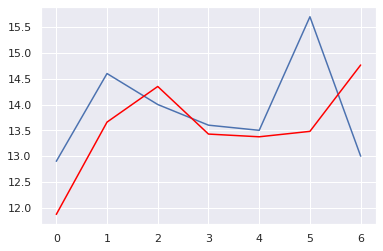

In [ ]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

file='https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/daily-temp.csv'
series = read_csv(file, header=0, index_col=0,parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('window',window)
print('coef',coef)
# walk forward over time steps in test
history = train[len(train)-window:] # 29 du lieu gan nhat cua train dung cho predict test
history = [history[i] for i in range(len(history))]
predictions = list()
print('history',history)
for t in range(len(test)):
  print(t,'-----------for 1')
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  yhat = coef[0]
  print('length',length)
  print('lag',lag)
  print('yhat',yhat)
  for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
    print(d,'for 2')
    print('coef[d+1]',coef[d+1])
    print('lag[window-d-1]',lag[window-d-1])
    print('yhat',yhat)

  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# Explain in excel file

# Chap 23 Moving Average Models for Forecasting

23.1 Model of Residual Errors

residual error = expected − predicted

In [ ]:
# calculate residual errors for a persistence forecast model
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe)
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
print(train_X.shape,test_X.shape)
# persistence model
predictions = [x for x in test_X]
# skill of persistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())

        t  t+1
0     NaN   35
1    35.0   32
2    32.0   30
3    30.0   31
4    31.0   44
..    ...  ...
360  34.0   37
361  37.0   52
362  52.0   48
363  48.0   55
364  55.0   50

[365 rows x 2 columns]
(239,) (125,)
Test RMSE: 9.151
      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


Autoregression of Residual Error

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]
Test RMSE: 9.151


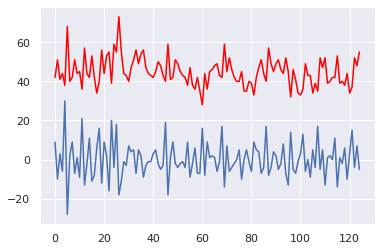

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
residuals_predict=list()
expected_error = list()
for t in range(len(test_y)):
  # persistence
  yhat = test_X[t]
  error = test_y[t] - yhat
  expected_error.append(error)
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
  residuals_predict.append(pred_error)
  predictions.append(yhat)
  history.append(error)
  #print('predicted error=%f, expected error=%f' % (pred_error, error))
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show() 

Explain

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
print('len_train_X',len(train_X))
print('train_X',train_X)
print('train_pred',train_pred)
print('train_y',train_y)
print('train_resid',train_resid)
print('test_X',test_X)
print('test_y',test_y)

len_train_X 239
train_X [35. 32. 30. 31. 44. 29. 45. 43. 38. 27. 38. 33. 55. 47. 45. 37. 50. 43.
 41. 52. 34. 53. 39. 32. 37. 43. 39. 35. 44. 38. 24. 23. 31. 44. 38. 50.
 38. 51. 31. 31. 51. 36. 45. 51. 34. 52. 47. 45. 46. 39. 48. 37. 35. 52.
 42. 45. 39. 37. 30. 35. 28. 45. 34. 36. 50. 44. 39. 32. 39. 45. 43. 39.
 31. 27. 30. 42. 46. 41. 36. 45. 46. 43. 38. 34. 35. 56. 36. 32. 50. 41.
 39. 41. 47. 34. 36. 33. 35. 38. 38. 34. 53. 34. 34. 38. 35. 32. 42. 34.
 46. 30. 46. 45. 54. 34. 37. 35. 40. 42. 58. 51. 32. 35. 38. 33. 39. 47.
 38. 52. 30. 34. 40. 35. 42. 41. 42. 38. 24. 34. 43. 36. 55. 41. 45. 41.
 37. 43. 39. 33. 43. 40. 38. 45. 46. 34. 35. 48. 51. 36. 33. 46. 42. 48.
 34. 41. 35. 40. 34. 30. 36. 40. 39. 45. 38. 47. 33. 30. 42. 43. 41. 41.
 59. 43. 45. 38. 37. 45. 42. 57. 46. 51. 41. 47. 26. 35. 44. 41. 42. 36.
 45. 45. 45. 47. 38. 42. 35. 36. 39. 45. 43. 47. 36. 41. 50. 39. 41. 46.
 64. 45. 34. 38. 44. 48. 46. 44. 37. 39. 44. 45. 33. 44. 38. 46. 46. 40.
 39. 44. 48. 50. 41.]
train

In [ ]:

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
print('history',history)
predictions = list()
expected_error = list()
for t in range(len(test_y)):#len(test_y)
  # persistence
  print(t,'-------------')
  yhat = test_X[t]
  error = test_y[t] - yhat
  print('yhat',yhat)
  print('error',error)
  expected_error.append(error)
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  print('len(history)',len(history))
  print('lag',lag)
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
    print('coef[d+1] ',coef[d+1] )
    print('lag[window-d-1]',lag[window-d-1])
    print('pred_error',pred_error)
  predictions.append(pred_error)
  history.append(error)
  print('predicted error=%f, expected error=%f' % (pred_error, error))
# error
print('expected_error',expected_error)
print('predictions',predictions)
#rmse = sqrt(mean_squared_error(test_y, yhat))
#print('Test RMSE: %.3f' % rmse)
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show() 
# Tu resid history co the predict resid giua y predic va y test

Streaming output truncated to the last 5000 lines.
yhat 55.0
error -11.0
len(history) 42
lag [-13.0, -2.0, 11.0, -11.0, -8.0, 6.0, 16.0, -12.0, 9.0, 2.0, -16.0, 20.0, -4.0, 18.0, -18.0]
coef[d+1]  -0.8494061537800464
lag[window-d-1] -18.0
pred_error 15.390517762773277
coef[d+1]  -0.777836088138751
lag[window-d-1] 18.0
pred_error 1.3894681762757575
coef[d+1]  -0.7334500572482245
lag[window-d-1] -4.0
pred_error 4.323268405268656
coef[d+1]  -0.689020613879255
lag[window-d-1] 20.0
pred_error -9.457143872316443
coef[d+1]  -0.5927055059380281
lag[window-d-1] -16.0
pred_error 0.02614422269200567
coef[d+1]  -0.5376728015574761
lag[window-d-1] 2.0
pred_error -1.0492013804229465
coef[d+1]  -0.4255335576185585
lag[window-d-1] 9.0
pred_error -4.879003398989973
coef[d+1]  -0.24861245690436343
lag[window-d-1] -12.0
pred_error -1.8956539161376114
coef[d+1]  -0.19972101537710887
lag[window-d-1] 16.0
pred_error -5.091190162171353
coef[d+1]  -0.15954012651273425
lag[window-d-1] 6.0
pred_error -6.0484309

TypeError: ignored

Correct Predictions with a Model of Residuals

A model of forecast residual error is interesting, but it can also be useful to make better
predictions. With a good estimate of forecast error at a time step, we can make better
predictions. For example, we can add the expected forecast error to a prediction to correct it
and in turn improve the skill of the model

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]
predictions [43.15552345054364, 43.89119067148698, 44.00748629526161, 43.24355434671726, 43.5111628630623, 48.008736410270075, 44.84242886199456, 45.05088305419858, 45.85841466120832, 45.16111915855916, 44.758071555684445, 45.15982604359746, 49.88202632611434, 45.18299217453097, 44.76936258268659, 48.04066335614627, 44.5662325149882, 43.084498380335276, 43.0208992067063, 49.457902490819365, 45.32811585365672, 45.22558832953407, 48.70592417807683, 44.16634446068361, 45.621870813498155, 47.96149734015738, 53.26443160593557, 50.637590717962446, 51.12328199852381, 50.78520002558342, 48.690567242372985, 50.50017418117621, 51.130549134910645, 54.18825121314103, 50.99545786518802, 49.40826571365572, 50.50545351160752, 47.02097528943373, 48.64149242977019, 50.20701652003057, 51.6130384848

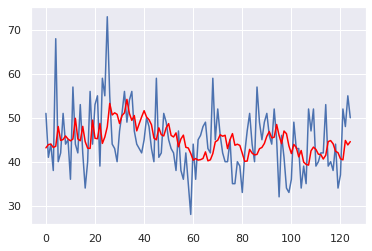

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
  # persistence
  yhat = test_X[t]
  error = test_y[t] - yhat
  expected_error.append(error)
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
  # correct the prediction
  yhat = yhat + pred_error
  predictions.append(yhat)
  history.append(error)
  #print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
print('predictions',predictions)
print('test_y',test_y)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show() 

# Chapter 24 ARIMA Model for Forecasting

 Autoregressive Integrated Moving Average Model

  AR: Autoregression. A model that uses the dependent relationship between an observation
and some number of lagged observations.

 I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation
from an observation at the previous time step) in order to make the time series stationary.

 MA: Moving Average. A model that uses the dependency between an observation and a
residual error from a moving average model applied to lagged observations.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


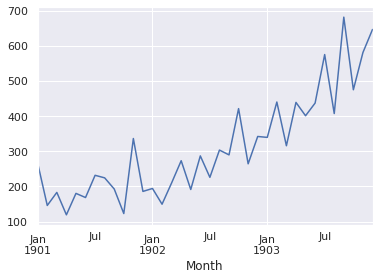

In [ ]:
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()


We can see that the Shampoo Sales dataset has a clear trend. This suggests that the time
series is not stationary and will require differencing to make it stationary, at least a difference
order of 1. Let’s also take a quick look at an autocorrelation plot of the time series. This is also
built-in to Pandas. The example below plots the autocorrelation for a large number of lags in
the time series

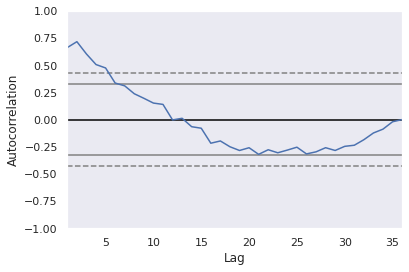

In [ ]:
# autocorrelation plot
autocorrelation_plot(series)
pyplot.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12
lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter
of the model may be 5.

24.3 ARIMA with Python

The Statsmodels library provides the capability to fit an ARIMA model. An ARIMA model
can be created using the Statsmodels library as follows:
1. Define the model by calling ARIMA()1 and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function2.
3. Predictions can be made by calling the predict() function3 and specifying the index of
the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo
Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the
lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary,
and uses a moving average model of 0. When fitting the model, a lot of debug information is
provided about the fit of the linear regression model. We can turn this off by setting the disp
argument to 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Thu, 02 Jul 2020   AIC                            406.340
Time:                        01:33:39   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

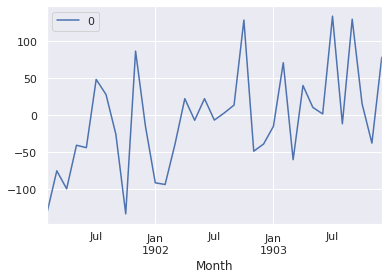

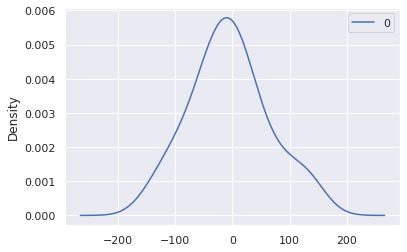

                0
count   35.000000
mean    -5.495267
std     68.132879
min   -133.296649
25%    -42.477975
50%     -7.186677
75%     24.748283
max    133.237923


In [ ]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

The distribution of the residual errors is displayed. The results show that indeed there is a
bias in the prediction (a non-zero mean in the residuals)

Note, that although above we used the entire dataset for time series analysis, ideally we
would perform this analysis on just the training dataset when developing a predictive model.
Next, let’s look at how we can use the ARIMA model to make forecasts.

24.4 Rolling Forecast ARIMA Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


predicted=349.117705, expected=342.300000
predicted=306.512977, expected=339.700000
predicted=387.376388, expected=440.400000
predicted=348.154194, expected=315.900000
predicted=386.308770, expected=439.300000
predicted=356.081960, expected=401.300000
predicted=446.379501, expected=437.400000
predicted=394.737276, expected=575.500000
predicted=434.915504, expected=407.600000
predicted=507.923350, expected=682.000000
predicted=435.482832, expected=475.300000
predicted=652.743765, expected=581.300000
predicted=546.343452, expected=646.900000
Test RMSE: 83.417


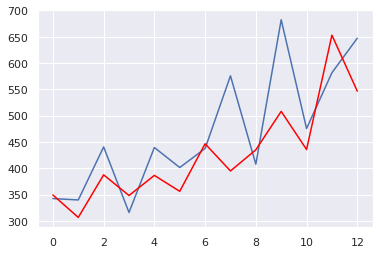

In [ ]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,1,0))
  # This sets the lag value to 5 for autoregression, uses a difference order of 1 to 
  # make the time series stationary, and uses a moving average model of 0.
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  #print('output',output)
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


# Chapter 25 Autocorrelation and Partial Autocorrelation

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 3650, dtype: float64


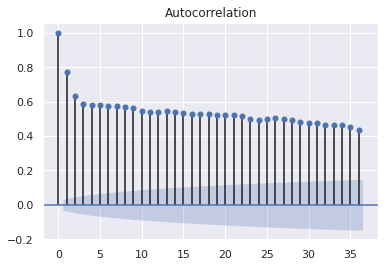

In [ ]:
# ACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                  header=0, index_col=0,parse_dates=True, squeeze=True)
print(series)
plot_acf(series)
pyplot.show()

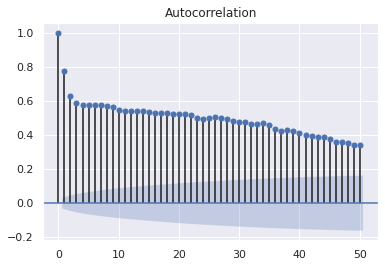

In [ ]:
plot_acf(series, lags=50)
pyplot.show()

25.3 Partial Autocorrelation Function

A partial autocorrelation is a summary of the relationship between an observation in a time
series with observations at prior time steps with the relationships of intervening observations
removed.

The autocorrelation for an observation and an observation at a prior time step is comprised
of both the direct correlation and indirect correlations. These indirect correlations are a linear
function of the correlation of the observation, with observations at intervening time steps. It is
these indirect correlations that the partial autocorrelation function seeks to remove. Without
going into the math, this is the intuition for the partial autocorrelation.

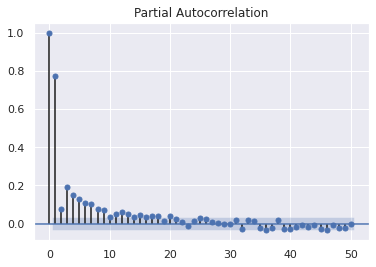

In [ ]:
# PACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                  header=0, index_col=0,parse_dates=True, squeeze=True)
plot_pacf(series, lags=50)
pyplot.show()

# Chapter 26 Grid Search ARIMA Model Hyperparameters

26.2 Evaluate ARIMA Model

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out-of-sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
        for q in q_values:
          order = (p,d,q)
          try:
            rmse = evaluate_arima_model(dataset, order)
            if rmse < best_score:
              best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
          except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

26.4 Shampoo Sales Case Study

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out-of-sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
        for q in q_values:
          order = (p,d,q)
          try:
            rmse = evaluate_arima_model(dataset, order)
            if rmse < best_score:
              best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
          except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.308
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=134.176
ARIMA(0, 1, 1) RMSE=97.767
ARIMA(0, 2, 0) RMSE=259.499
ARIMA(0, 2, 1) RMSE=135.361
ARIMA(1, 0, 0) RMSE=152.030
ARIMA(1, 1, 0) RMSE=84.388
ARIMA(1, 1, 1) RMSE=83.688
ARIMA(1, 2, 0) RMSE=136.411
ARIMA(2, 0, 0) RMSE=101.410
ARIMA(2, 1, 0) RMSE=75.432
ARIMA(2, 1, 1) RMSE=88.089
ARIMA(2, 2, 0) RMSE=99.302
ARIMA(4, 1, 0) RMSE=81.545
ARIMA(4, 1, 1) RMSE=82.440
ARIMA(4, 2, 0) RMSE=87.157
ARIMA(4, 2, 1) RMSE=68.519
ARIMA(6, 0, 0) RMSE=90.525
ARIMA(6, 1, 0) RMSE=82.523
ARIMA(6, 1, 1) RMSE=66.597
ARIMA(6, 2, 0) RMSE=79.127
ARIMA(8, 1, 0) RMSE=81.115
ARIMA(10, 1, 0) RMSE=86.789
Best ARIMA(6, 1, 1) RMSE=66.597


Another method

In [ ]:
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
timeseries = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-shampoo-sales.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True, date_parser=parser)

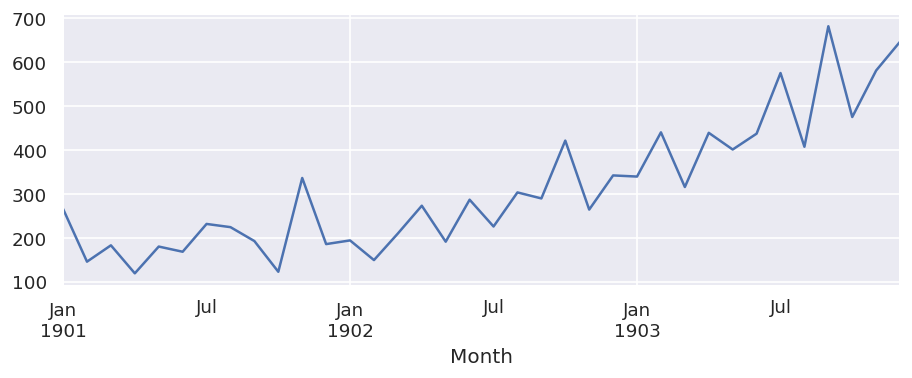

In [ ]:
timeseries.plot()

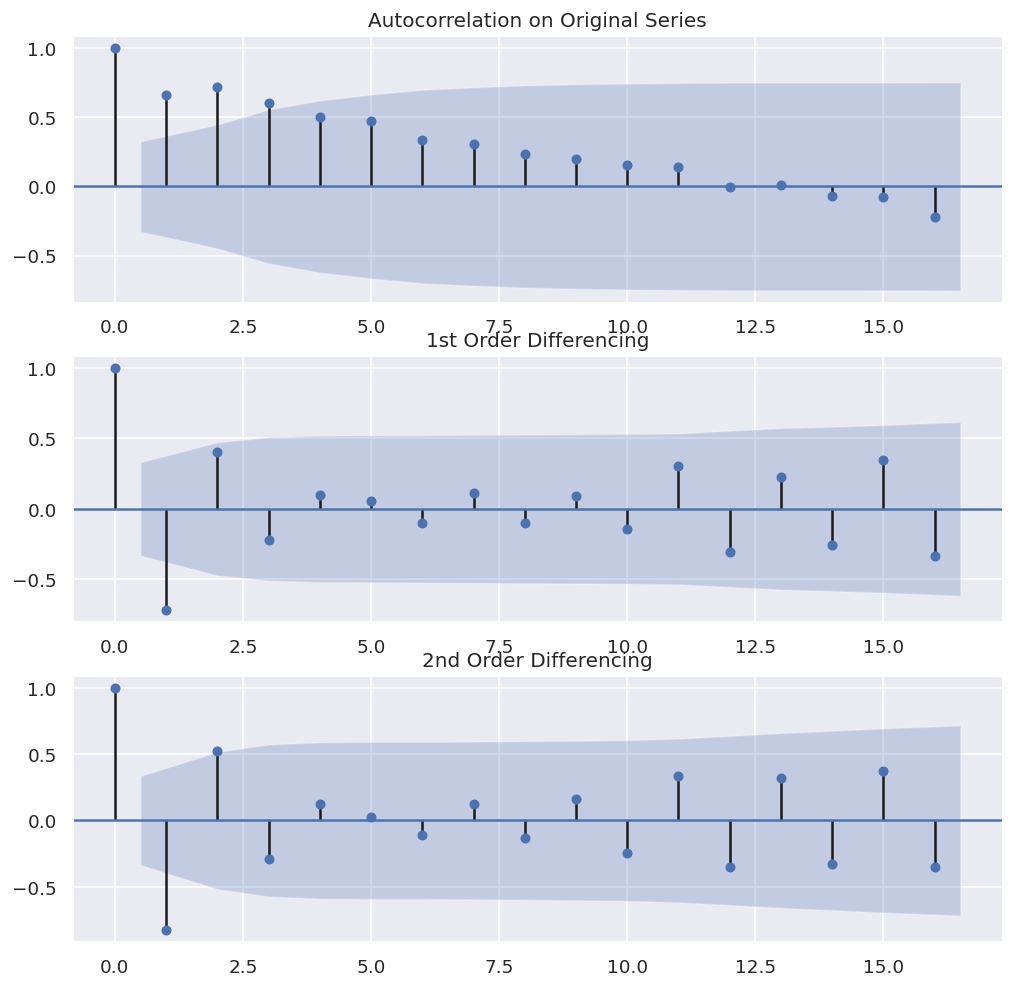

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

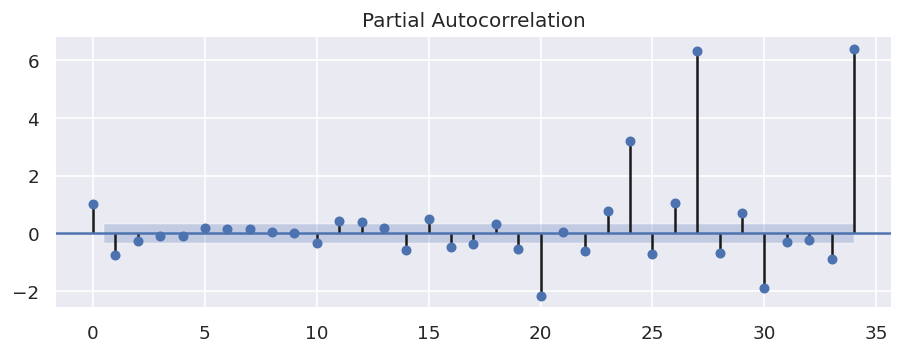

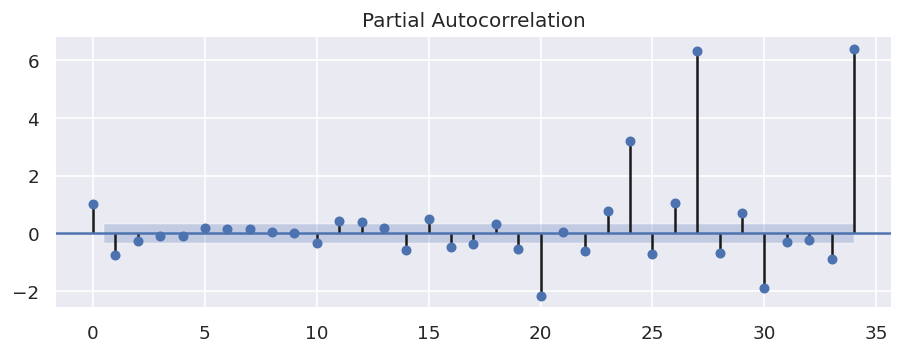

In [ ]:
#p value
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once

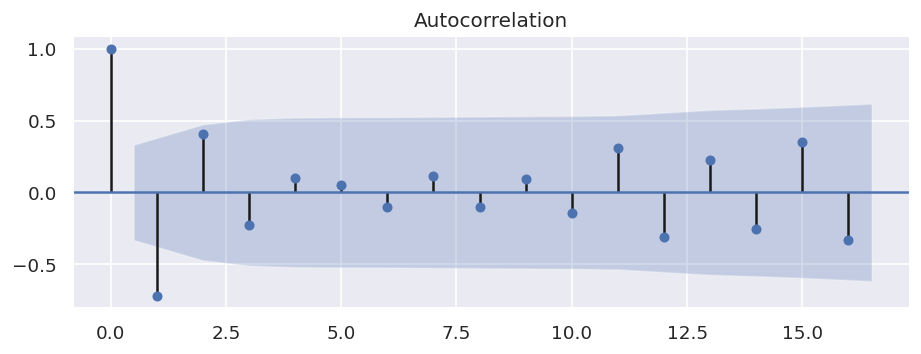

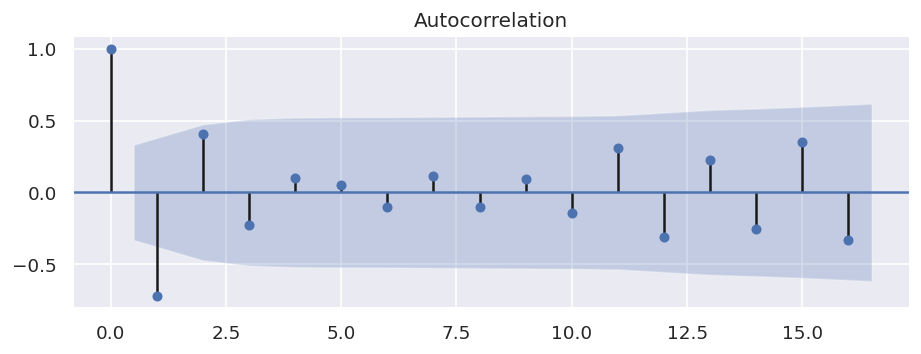

In [ ]:
# q value
plot_acf(timeseries.diff().dropna())

In [ ]:
model = ARIMA(timeseries, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.233
Method:                       css-mle   S.D. of innovations             66.625
Date:                Thu, 02 Jul 2020   AIC                            402.467
Time:                        05:17:37   BIC                            408.688
Sample:                    02-01-1901   HQIC                           404.614
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0965      3.651      3.313      0.002       4.940      19.253
ar.L1.D.Sales    -0.5674      0.161     -3.526      0.001      -0.883      -0.252
ma.L1.D.Sales    -0.5133      0.155     

In [ ]:
evaluate_arima_model(timeseries,(6,1,1))

68.67146435878689

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [ ]:
len(test)

13

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   22
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -121.457
Method:                       css-mle   S.D. of innovations             58.109
Date:                Thu, 02 Jul 2020   AIC                            260.915
Time:                        05:27:18   BIC                            270.734
Sample:                             1   HQIC                           263.228
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1834      3.722      1.930      0.074      -0.111      14.478
ar.L1.D.y     -0.6249      1.405     -0.445      0.663      -3.380       2.130
ar.L2.D.y     -0.2903      1.456     -0.199      0.8

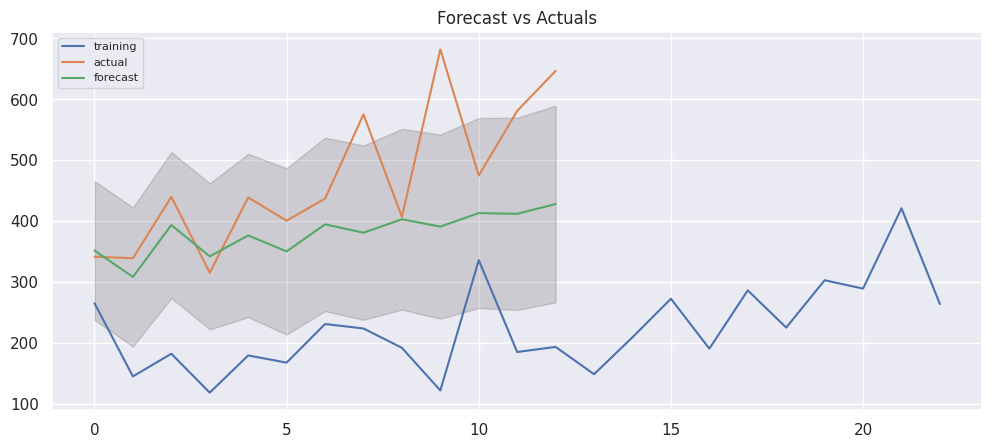

In [ ]:
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
# Build Model
model = ARIMA(train, order=(6, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, #index=test
                      )
lower_series = pd.Series(conf[:, 0], #index=test
                         )
upper_series = pd.Series(conf[:, 1], #index=test
                         )

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

26.5 Daily Female Births Case Study

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 0, 2) RMSE=7.771
ARIMA(0, 1, 0) RMSE=9.167
ARIMA(0, 1, 1) RMSE=7.527
ARIMA(0, 1, 2) RMSE=7.434
ARIMA(0, 2, 0) RMSE=15.698
ARIMA(0, 2, 1) RMSE=9.201
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.554
ARIMA(1, 1, 0) RMSE=8.120
ARIMA(1, 1, 1) RMSE=7.425
ARIMA(1, 1, 2) RMSE=7.429
ARIMA(1, 2, 0) RMSE=11.990
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.421
ARIMA(2, 0, 2) RMSE=7.447
ARIMA(2, 1, 0) RMSE=7.713
ARIMA(2, 1, 1) RMSE=7.417
ARIMA(2, 1, 2) RMSE=7.433
ARIMA(2, 2, 0) RMSE=10.373
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.829
ARIMA(4, 0, 2) RMSE=7.474
ARIMA(4, 1, 0) RMSE=7.578
ARIMA(4, 1, 1) RMSE=7.474
ARIMA(4, 1, 2) RMSE=7.455
ARIMA(4, 2, 0) RMSE=8.956
ARIMA(6, 0, 0) RMSE=7.666
ARIMA(6, 0, 1) RMSE=7.711
ARIMA(6, 1, 0) RMSE=7.293
ARIMA(6, 1, 1) RMSE=7.554
ARIMA(6, 1, 2) RMSE=7.463
ARIMA(6, 2, 0) RMSE=8.352
ARIMA(8, 0, 0) RMSE=7.549
ARIMA(8, 0, 1) RMSE=7.565
ARIMA(8, 0, 2) RMSE=7.625
ARIMA(8, 1, 0) RMSE=7.569
ARIMA(8, 

Another method

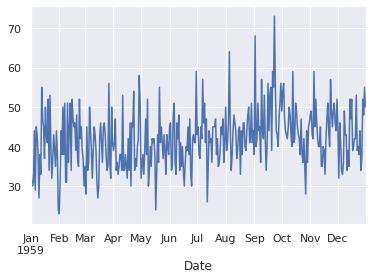

In [ ]:
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
series.plot()

In [ ]:
series_df=DataFrame(series)
series_df

Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44
...            ...
1959-12-27      37
1959-12-28      52
1959-12-29      48
1959-12-30      55
1959-12-31      50

[365 rows x 1 columns]

Find d

In [ ]:
result = adfuller(series_df.Births)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

(-4.808291253559765, 5.2434129901498554e-05, 6, 358, {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}, 2343.8290926464197)
ADF Statistic: -4.808291
p-value: 0.000052


p value < 0.05 --> stationary (not trend or seasons)

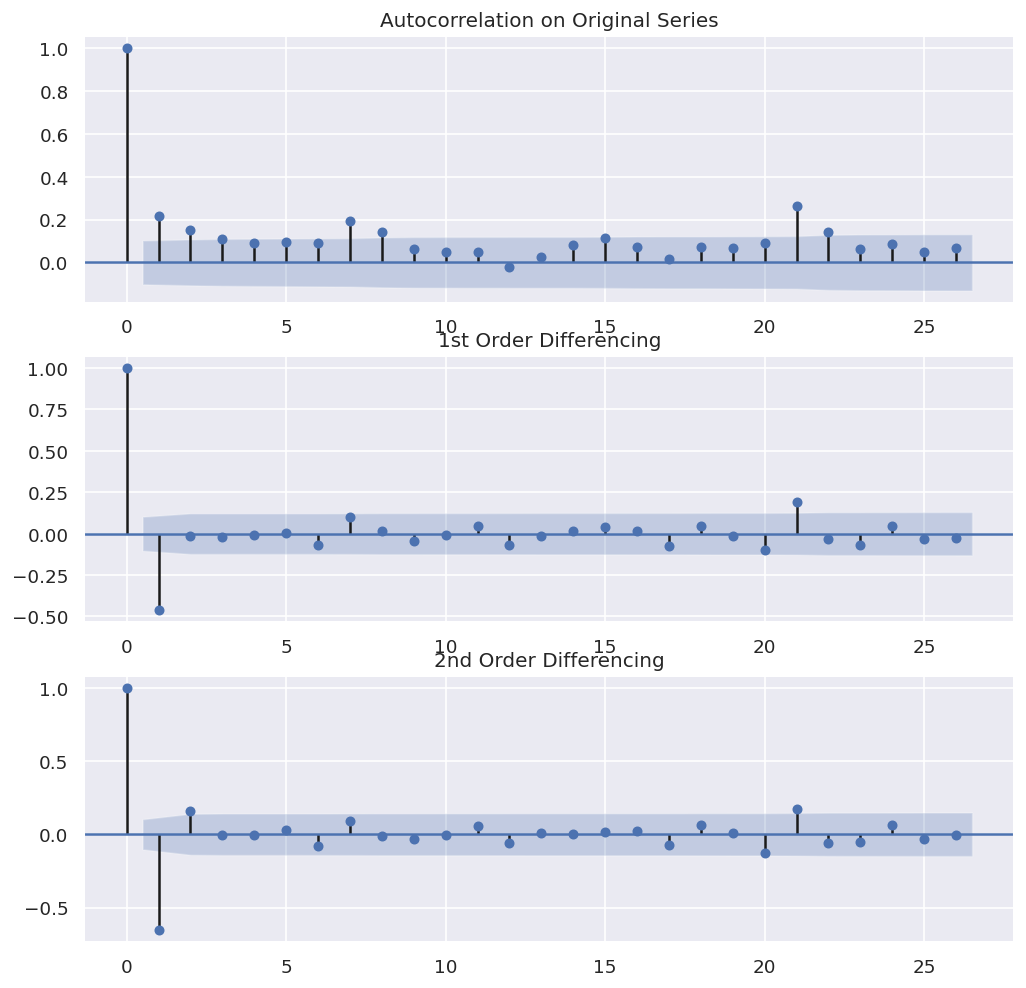

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(series, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(series.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(series.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

How to find the order of the AR term (p)

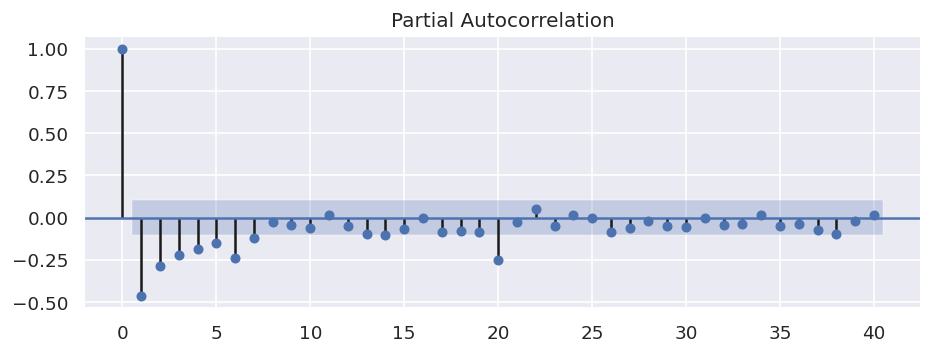

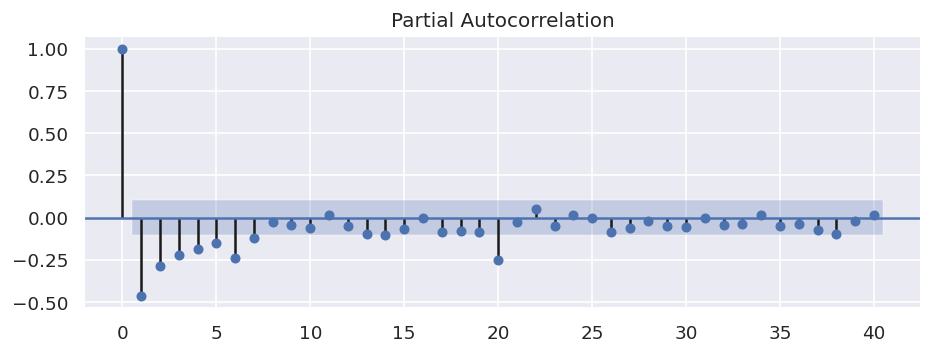

In [ ]:
plot_pacf(series.diff().dropna(), lags=40) #knowing d=1 we apply diff() once

Number of q using autocorrelation on the stationary series

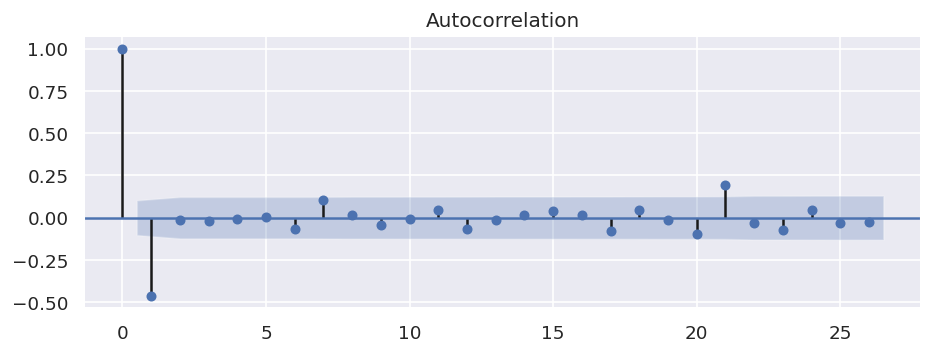

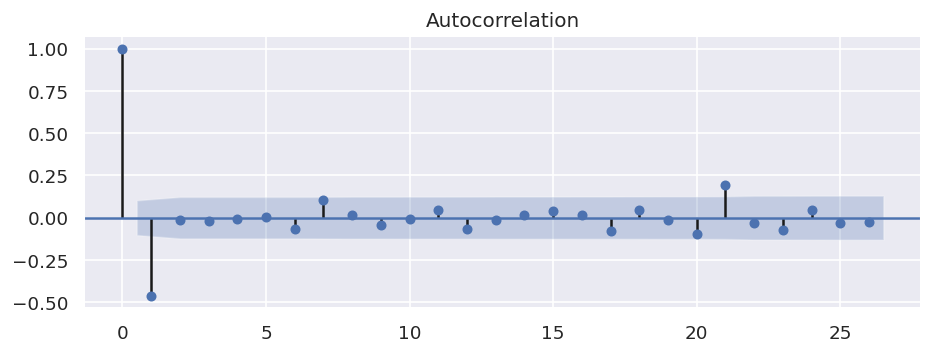

In [ ]:
plot_acf(series.diff().dropna())

In [ ]:
len(series)

365

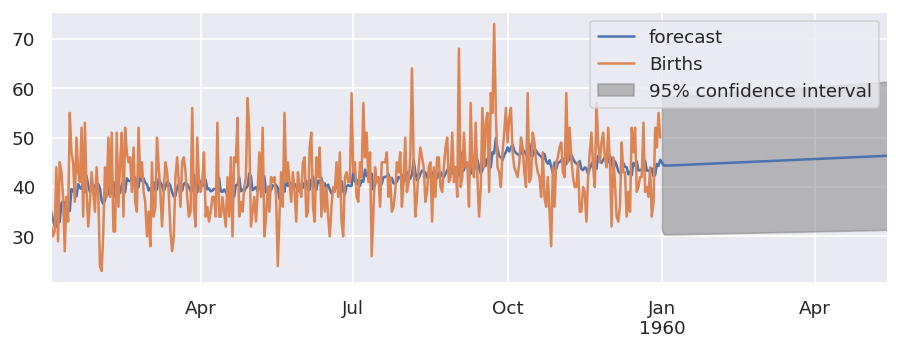

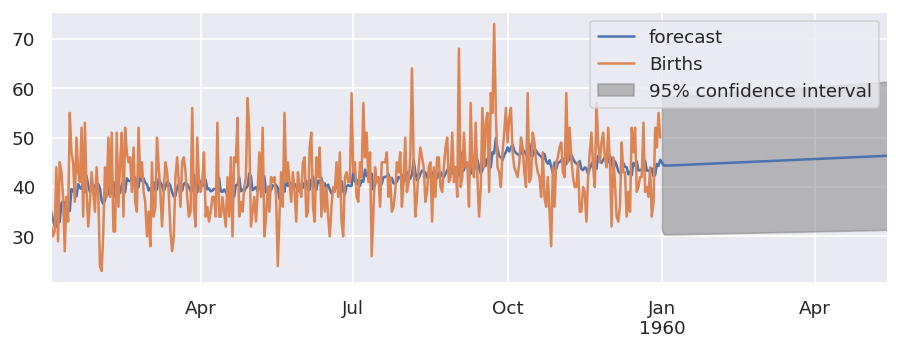

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(1, 1, 1)) #6,1,0
results = model.fit()
results.plot_predict(1,500) 

In [ ]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1226.077
Method:                       css-mle   S.D. of innovations              7.000
Date:                Thu, 02 Jul 2020   AIC                           2460.154
Time:                        05:11:25   BIC                           2475.742
Sample:                    01-02-1959   HQIC                          2466.350
                         - 12-31-1959                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0152      0.014      1.068      0.286      -0.013       0.043
ar.L1.D.Births     0.1299      0.056      2.334      0.020       0.021       0.239
ma.L1.D.Births    -0.9694      0.019

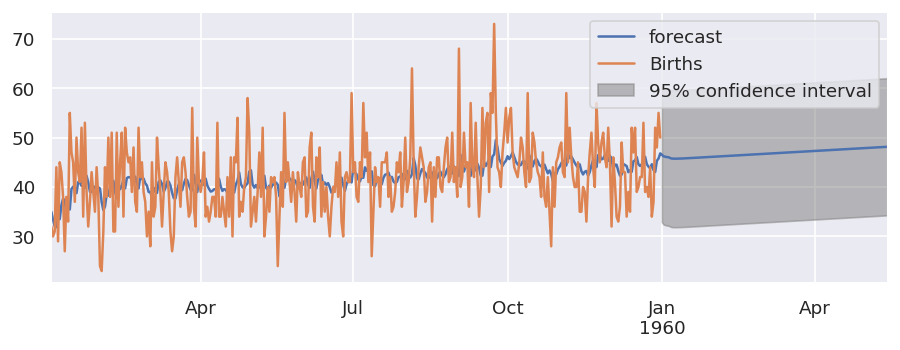

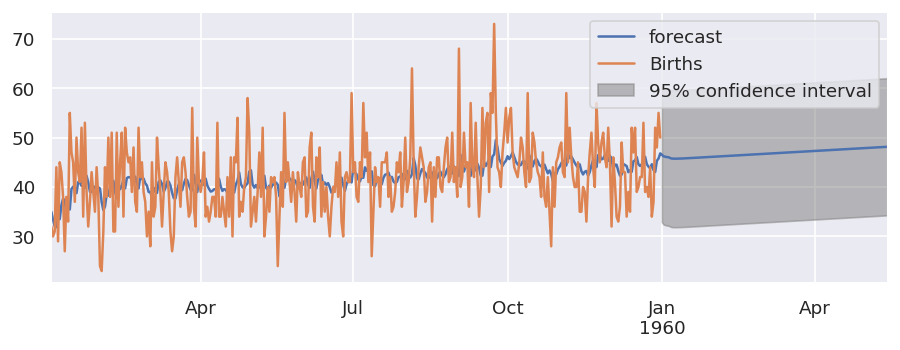

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(6, 1, 1)) #6,1,0
results = model.fit()
results.plot_predict(1,500) 

In [ ]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                  364
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1225.306
Method:                       css-mle   S.D. of innovations              6.959
Date:                Thu, 02 Jul 2020   AIC                           2468.612
Time:                        05:14:40   BIC                           2503.687
Sample:                    01-02-1959   HQIC                          2482.553
                         - 12-31-1959                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0194      0.005      4.026      0.000       0.010       0.029
ar.L1.D.Births     0.1456      0.052      2.776      0.006       0.043       0.248
ar.L2.D.Births     0.0659      0.053

# Chapter 27 Save Models and Make Predictions

Test RMSE: 7.259


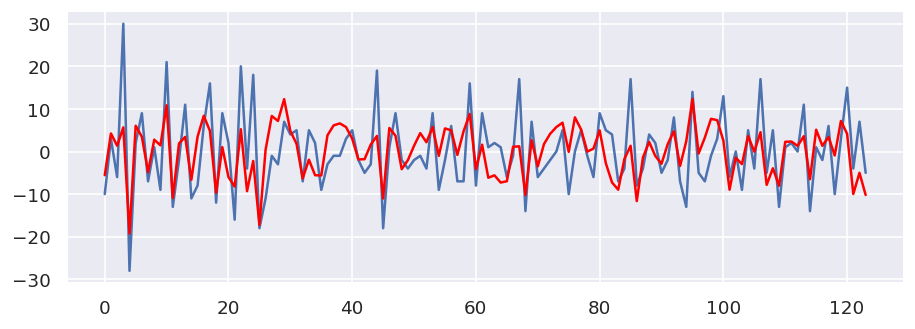

In [ ]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

# create a difference transform of the dataset
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return numpy.array(diff)
# Make a prediction give regression coefficients and lag obs

def predict(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat
  
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)

# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
  yhat = predict(coef, history)
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

# create a difference transform of the dataset
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return numpy.array(diff)
# Make a prediction give regression coefficients and lag obs

def predict(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat
  
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)

# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

In [ ]:
# load the AR model from file
from statsmodels.tsa.ar_model import ARResults
import numpy
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.16061001 -0.76616332 -0.63670616 -0.55537201 -0.45887026 -0.32989392
 -0.19056962]
[50]


In [ ]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

# create a difference transform of the dataset
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return numpy.array(diff)
# Make a prediction give regression coefficients and lag obs

def predict(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat
  
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)

# split dataset
X = difference(series.values)

# fit model
window_size = 6
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

In [ ]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


In [ ]:
# load a coefficients and from file and make a manual prediction
import numpy
def predict(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat
# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


27.6 Update Forecast Model

In [ ]:
# update the data for the AR model with a new obs
import numpy
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

In [ ]:
# update the data for the manual model with a new obs
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

# Chapter 28 Forecast Confidence Intervals

In [ ]:
# summarize the confidence interval on an ARIMA forecast
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
# load dataset
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# forecast
forecast, stderr, conf = model_fit.forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 50.000
Forecast: 45.878
Standard Error: 6.996
95% Confidence Interval: 32.167 to 59.590


In [ ]:
# summarize the confidence interval on an ARIMA forecast
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
# load dataset
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',
                  header=0, index_col=0, parse_dates=True,squeeze=True)

# split data into train and test setes
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
  forecast, stderr, conf = model_fit.forecast(alpha=a)
  print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast,
  conf[0][0], conf[0][1]))

80.0% Confidence Interval: 45.878 between 36.913 and 54.844
90.0% Confidence Interval: 45.878 between 34.371 and 57.386
95.0% Confidence Interval: 45.878 between 32.167 and 59.590
99.0% Confidence Interval: 45.878 between 27.858 and 63.898


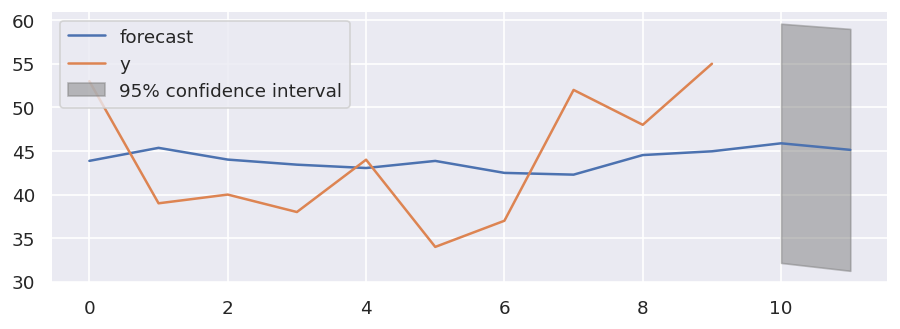

In [ ]:
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(train)-10, len(train)+1)
pyplot.legend(loc='upper left')
pyplot.show()